In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import verde as vd
import harmonica as hm
import boule as bl
import ensaio
import pygmt
import pyproj

# import utm
import geopandas as gpd

import pathlib
import os

import warnings
warnings.filterwarnings("ignore")

# Load gravity data table

In [49]:
data_dir = pathlib.Path("..") / "data"
image_dir = pathlib.Path("..") / "report" / "figures"
shape_dir = pathlib.Path("..") / "data" / "shapefile"

mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

Read shapefile

In [98]:
pluton = os.path.join(data_dir/"corrego_seco.shp")
regional = hm.load_icgem_gdf( pathlib.Path("..") / "data" / "gravity_ell_EGM2008.gdf")

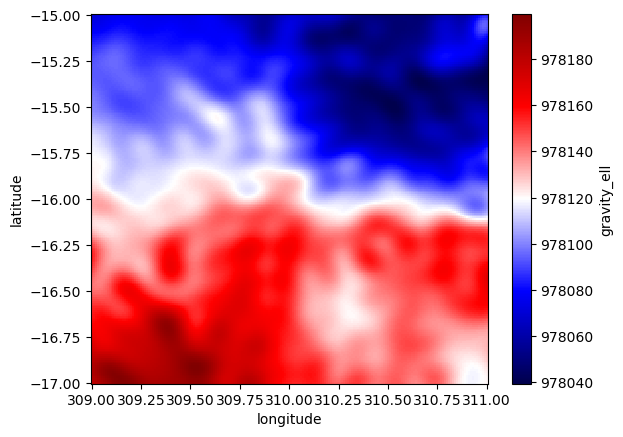

In [100]:
regional
regional.gravity_ell.plot.pcolormesh(cmap="seismic")

In [51]:
# Dados Regionais BNDG
df_regional = pd.read_csv(data_dir/'regional.csv', delimiter=',')

df_regional.rename(columns={'GOBS': 'Gravity'}, inplace=True)
df_regional.rename(columns={'LATITUDE': 'Latitude'}, inplace=True)
df_regional.rename(columns={'LONGITUDE': 'Longitude'}, inplace=True)
df_regional.rename(columns={'ALT_ORT': 'Elevation'}, inplace=True)
df_regional.rename(columns={'Line': 'Station'}, inplace=True)

colunas_especificas = ['Latitude', 'Longitude', 'Gravity', 'Elevation', 'Station']
df_regional = df_regional[colunas_especificas]

# Dados Locais
df_local = pd.read_csv(data_dir/'CSG.csv', delimiter=',')
df_local = df_local[colunas_especificas]

data = pd.concat([df_regional, df_local], ignore_index=True)

# data = df_local

len(data['Latitude'])

220

In [52]:
valores_a_remover = ['csg5_001', 'csg5_003', 'csg2_005', 'csg9_001']
data = data[~data['Station'].isin(valores_a_remover)]

In [97]:
# West, East, South, North (degrees)
lat_max = np.max(data.Latitude)
lat_min = np.min(data.Latitude)
lon_max = np.max(data.Longitude)
lon_min = np.min(data.Longitude)
region = (lon_min, lon_max, lat_min, lat_max)
# Pad the region for slicing the grids
# region_pad = vd.pad_region(region, pad=-0.15)
region_pad = vd.pad_region(region, pad=0.1)

# data = data[
#     (data['Longitude'] >= region_pad[0]) & (data['Longitude'] <= region_pad[1]) &
#     (data['Latitude'] >= region_pad[2]) & (data['Latitude'] <= region_pad[3])
# ]
# len(data['Longitude'])
print(region_pad)

(-50.36200556, -49.59158056, -16.761389, -16.026)


In [54]:
topography = pygmt.datasets.load_earth_relief(resolution="01s", region=region_pad)
topography = topography.rename({'lon': 'longitude', 'lat': 'latitude'})
topography

grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -50.36200556 to -50.3622222222
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -49.59158056 to -49.5913888889
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from -16.761389 to -16.7616666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from -16.026 to -16.0258333333


<xarray.DataArray 'elevation' (latitude: 2656, longitude: 2791)> Size: 30MB
array([[615., 614., 613., ..., 716., 717., 719.],
       [612., 612., 611., ..., 718., 719., 721.],
       [611., 611., 611., ..., 719., 720., 721.],
       ...,
       [510., 510., 512., ..., 724., 724., 726.],
       [510., 511., 512., ..., 724., 723., 724.],
       [510., 512., 514., ..., 724., 723., 725.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 22kB -50.36 -50.36 -50.36 ... -49.59 -49.59
  * latitude   (latitude) float64 21kB -16.76 -16.76 -16.76 ... -16.03 -16.02
Attributes:
    long_name:         Earth elevation relative to the geoid
    cpt:               geo
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

In [55]:
topography = topography.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
# topography = topography.sel(lon=slice(*region_pad[:2]), lat=slice(*region_pad[2:]))
topography

<xarray.DataArray 'elevation' (latitude: 2648, longitude: 2774)> Size: 29MB
array([[609., 608., 611., ..., 701., 702., 704.],
       [610., 610., 611., ..., 700., 701., 702.],
       [613., 612., 614., ..., 700., 701., 702.],
       ...,
       [518., 518., 518., ..., 751., 750., 749.],
       [516., 517., 517., ..., 751., 749., 748.],
       [514., 515., 516., ..., 750., 748., 747.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 22kB -50.36 -50.36 -50.36 ... -49.59 -49.59
  * latitude   (latitude) float64 21kB -16.76 -16.76 -16.76 ... -16.03 -16.03
Attributes:
    long_name:         Earth elevation relative to the geoid
    cpt:               geo
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

In [56]:
geoid = pygmt.datasets.load_earth_geoid(resolution="01m", region=region_pad, registration="gridline")
geoid = geoid.rename({'lon': 'longitude', 'lat': 'latitude'})

geoid = geoid.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
interpolator = vd.KNeighbors()

geoid_table = vd.grid_to_table(geoid)
geoid_1 = vd.grid_to_table(topography)


interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.earth_geoid)
geoid_1 = geoid_1.assign(elevation=interpolator.predict((geoid_1.longitude, geoid_1.latitude)))

geoid_values = np.reshape(geoid_1.elevation, topography.shape)
geoid = xr.DataArray(geoid_values, coords=[topography.latitude, topography.longitude], dims=['latitude', 'longitude'])
geoid

grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -50.36200556 to -50.3666666667
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -49.59158056 to -49.5833333333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from -16.761389 to -16.7666666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from -16.026 to -16.0166666667


<xarray.DataArray (latitude: 2648, longitude: 2774)> Size: 29MB
array([[-6.2999997, -6.2999997, -6.2999997, ..., -9.28     , -9.28     ,
        -9.28     ],
       [-6.2999997, -6.2999997, -6.2999997, ..., -9.28     , -9.28     ,
        -9.28     ],
       [-6.2999997, -6.2999997, -6.2999997, ..., -9.28     , -9.28     ,
        -9.28     ],
       ...,
       [-6.81     , -6.81     , -6.81     , ..., -9.11     , -9.11     ,
        -9.11     ],
       [-6.81     , -6.81     , -6.81     , ..., -9.11     , -9.11     ,
        -9.11     ],
       [-6.81     , -6.81     , -6.81     , ..., -9.11     , -9.11     ,
        -9.11     ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 21kB -16.76 -16.76 -16.76 ... -16.03 -16.03
  * longitude  (longitude) float64 22kB -50.36 -50.36 -50.36 ... -49.59 -49.59

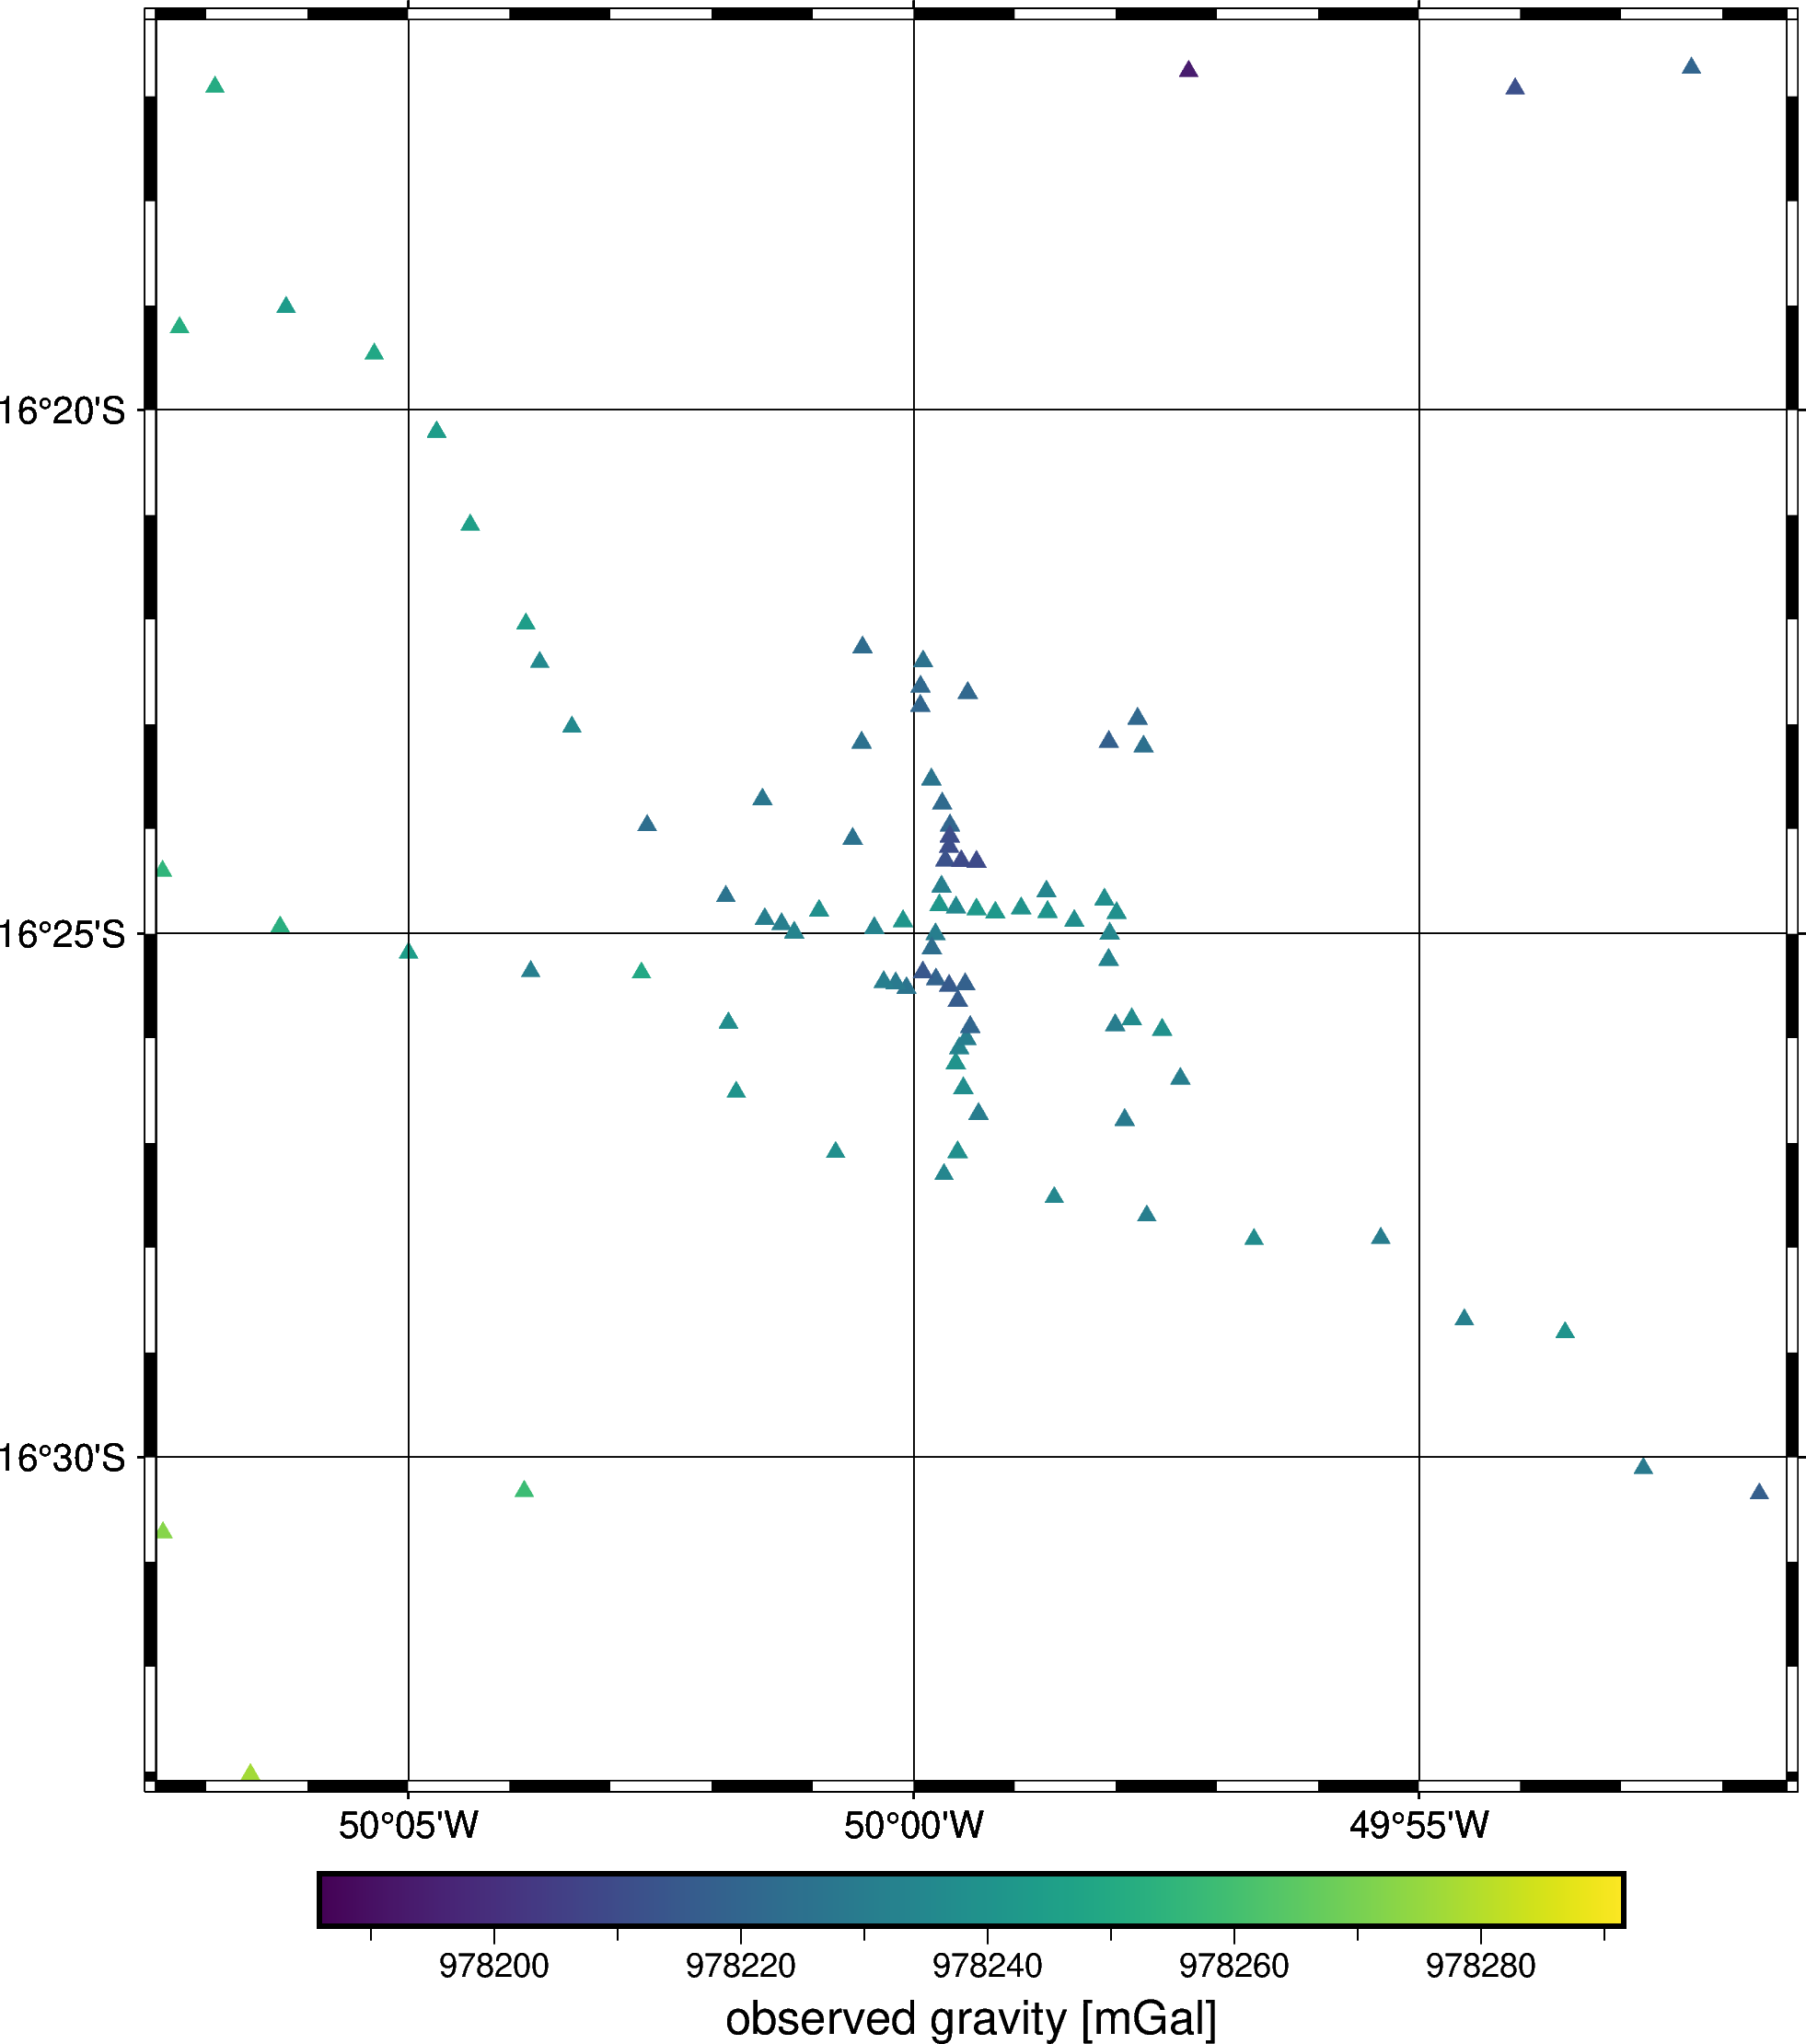

In [57]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="viridis", series=[data.Gravity.min(), data.Gravity.max()])
fig.plot(
    x=df_regional.Longitude,
    y=df_regional.Latitude,
    color=df_regional.Gravity,
    cmap=True,
    style="t0.2c",
    projection="M15c",
    frame="afg",
)

fig.plot(
    x=df_local.Longitude,
    y=df_local.Latitude,
    color=df_local.Gravity,
    cmap=True,
    style="t6p",
    projection="M15c",
    frame="afg",
)
fig.colorbar(frame='af+l"observed gravity [mGal]"')

fig.show(width=600)

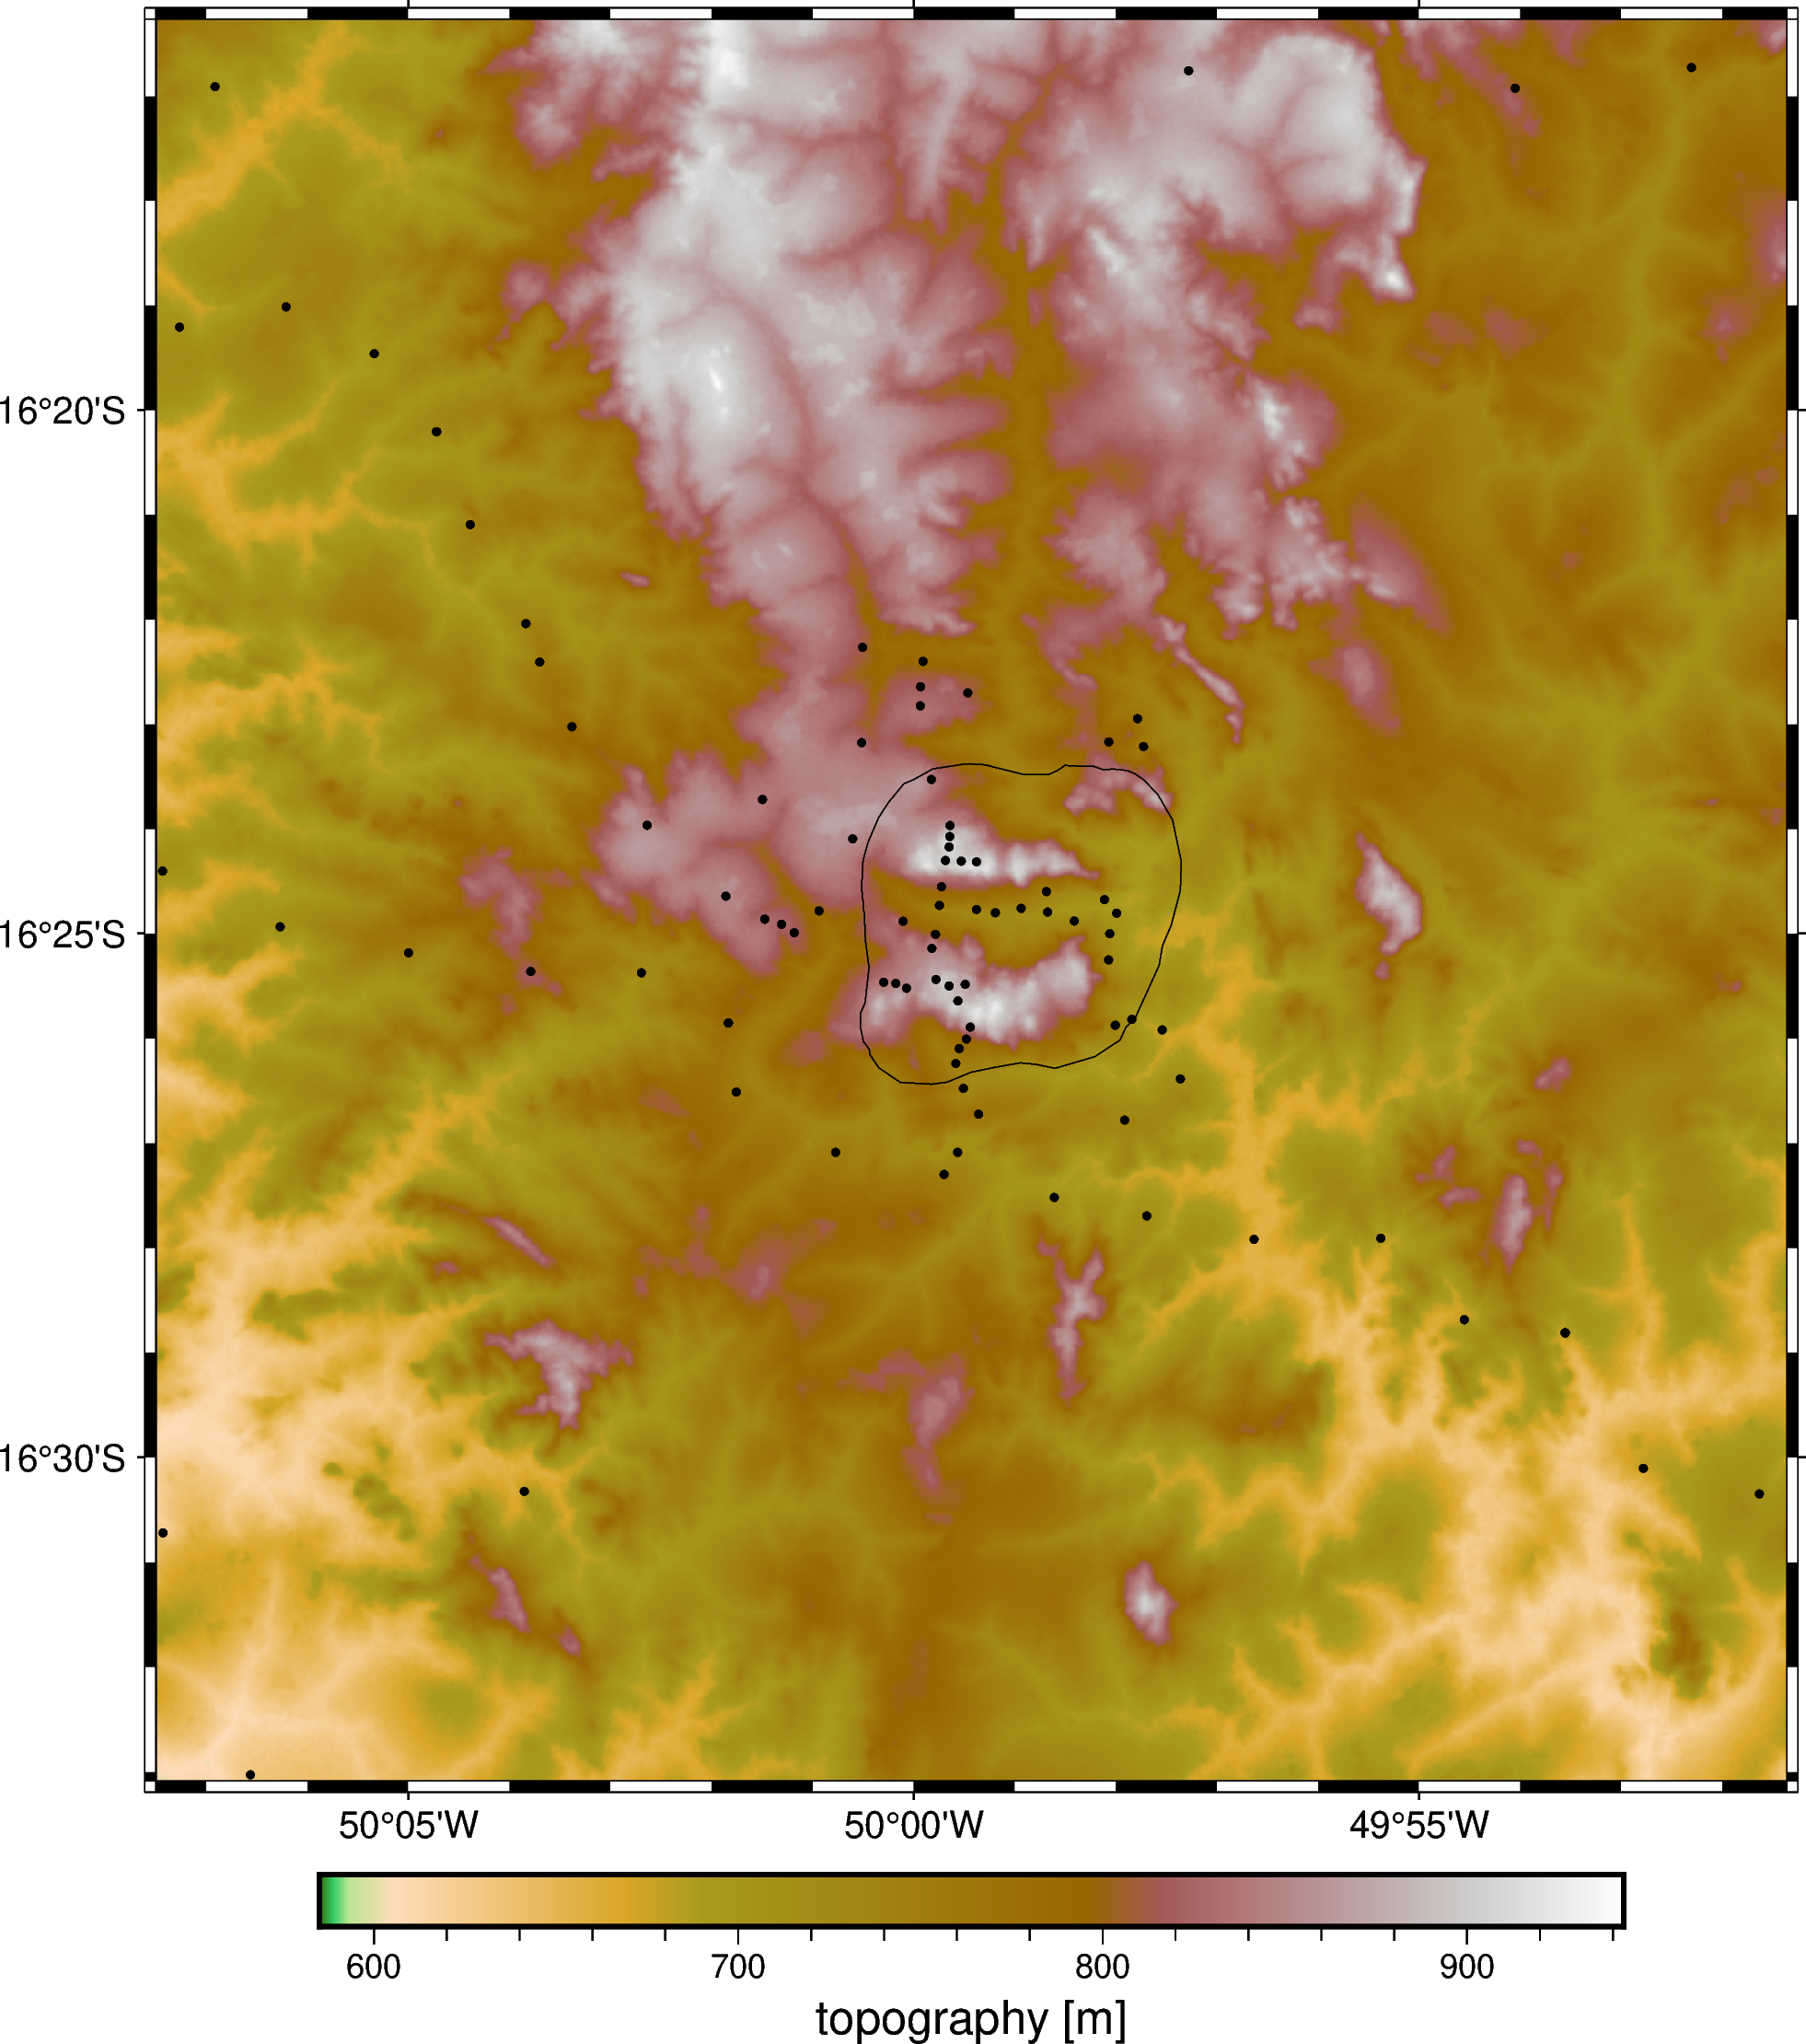

In [60]:
fig = pygmt.Figure()
fig.grdimage(topography, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"topography [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.08c",
    color="black",
)
fig.plot(data=pluton, projection='M')
fig.show(width=600)

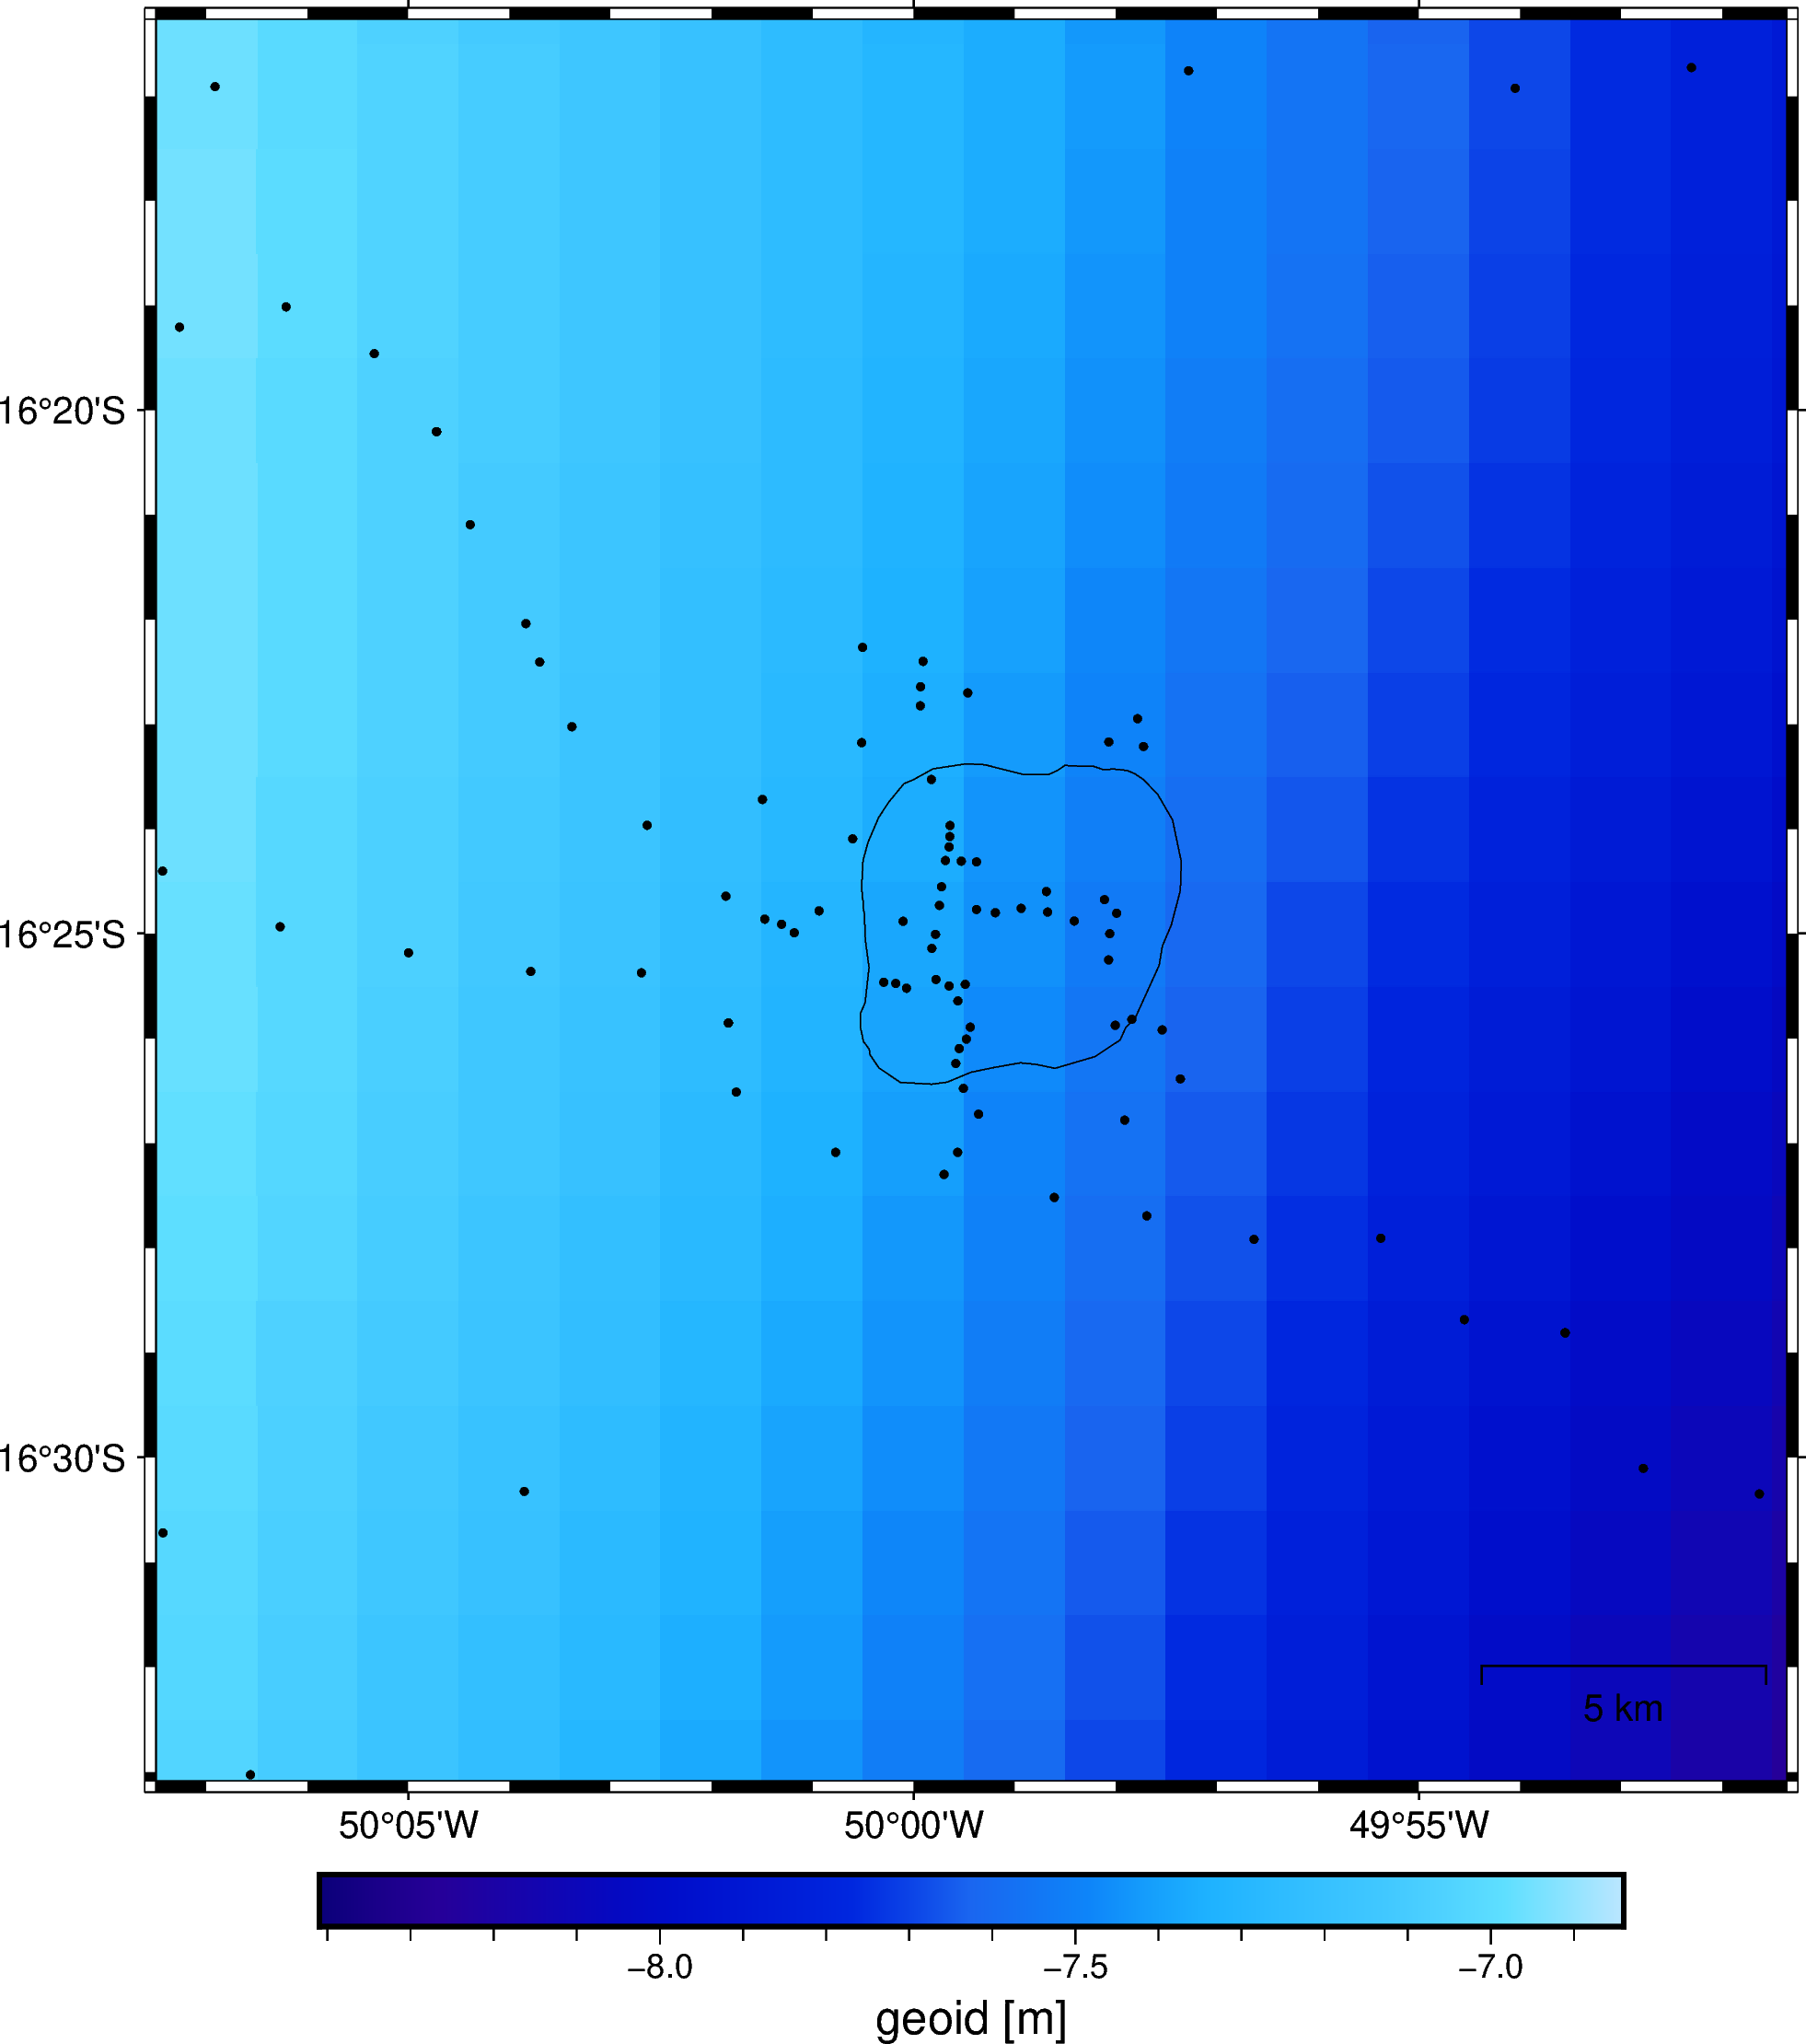

In [61]:
fig = pygmt.Figure()
fig.grdimage(geoid, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"geoid [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.08c",
    color="black",
)
fig.plot(data=pluton, projection='M')
fig.basemap(map_scale="n0.9/0.06+w5k+u")
fig.show(width=600)

## Converte altitudes ortométricas para geométricas

In [64]:
topography_geometric = topography + geoid
topography_geometric

<xarray.DataArray (latitude: 2648, longitude: 2774)> Size: 29MB
array([[602.7 , 601.7 , 604.7 , ..., 691.72, 692.72, 694.72],
       [603.7 , 603.7 , 604.7 , ..., 690.72, 691.72, 692.72],
       [606.7 , 605.7 , 607.7 , ..., 690.72, 691.72, 692.72],
       ...,
       [511.19, 511.19, 511.19, ..., 741.89, 740.89, 739.89],
       [509.19, 510.19, 510.19, ..., 741.89, 739.89, 738.89],
       [507.19, 508.19, 509.19, ..., 740.89, 738.89, 737.89]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 22kB -50.36 -50.36 -50.36 ... -49.59 -49.59
  * latitude   (latitude) float64 21kB -16.76 -16.76 -16.76 ... -16.03 -16.03

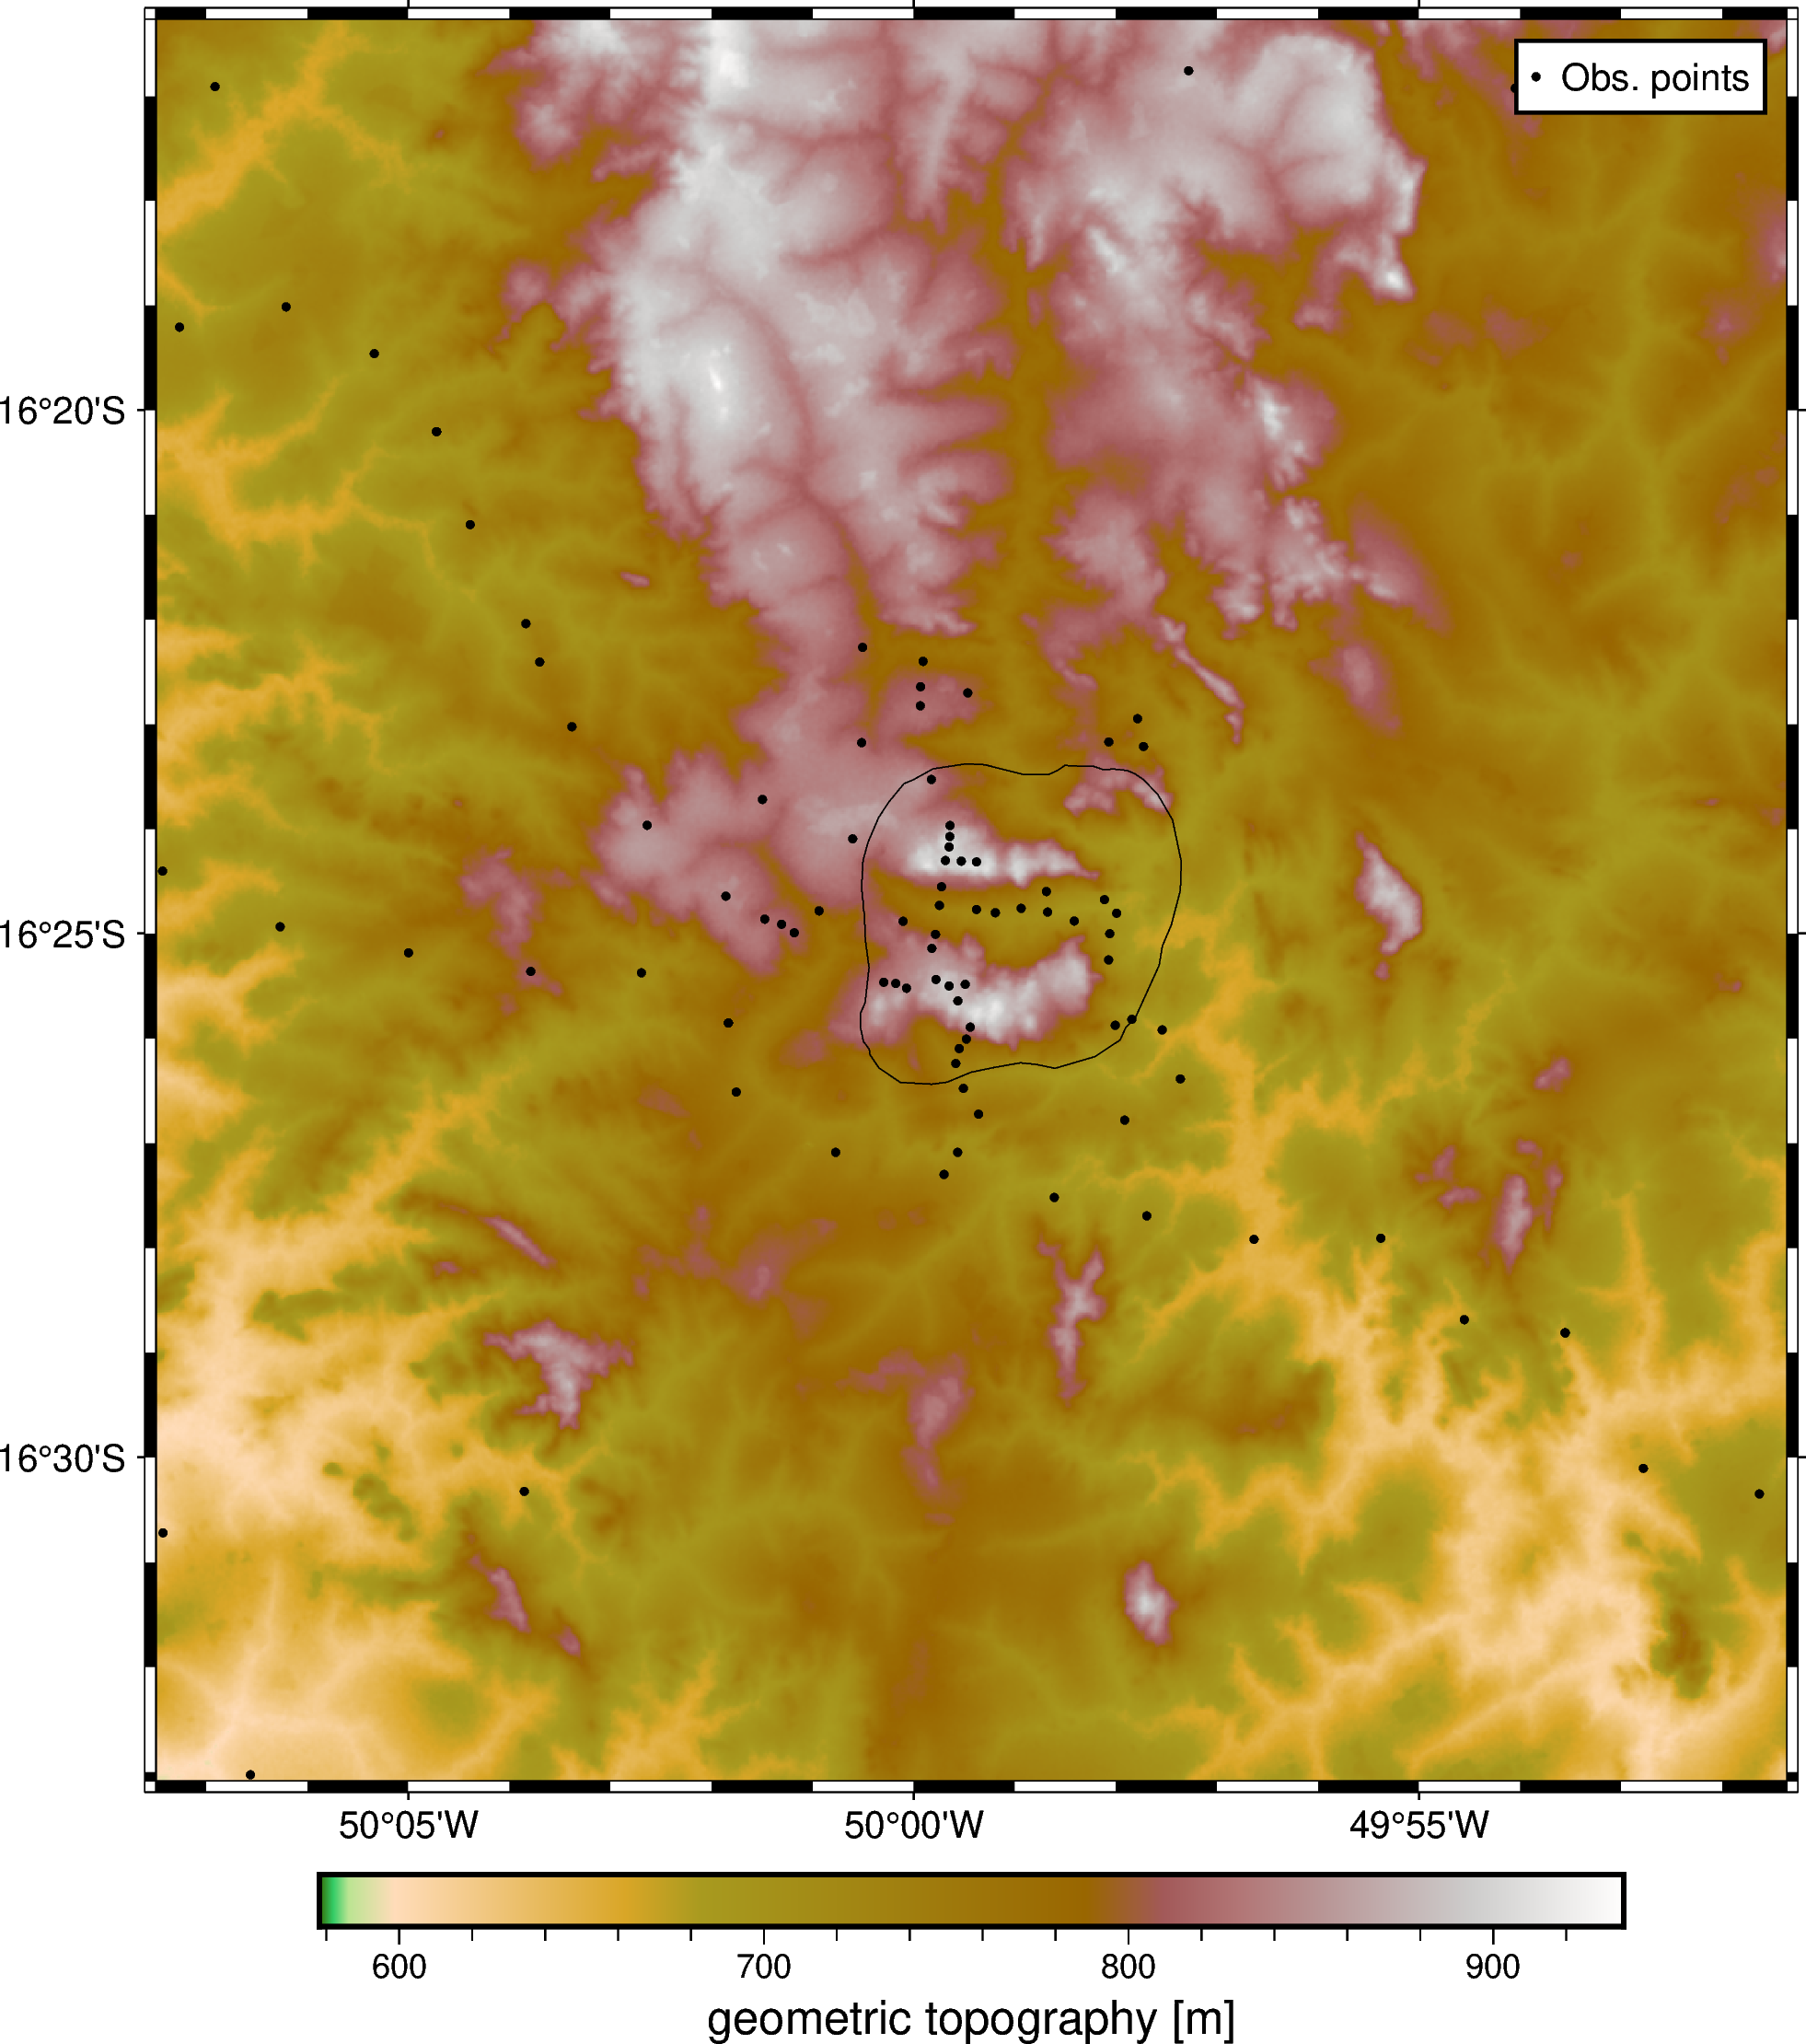

In [65]:
fig = pygmt.Figure()
fig.grdimage(topography_geometric, projection="M15c", cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"geometric topography [m]"')
fig.coast(shorelines="white", area_thresh=1e6)
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.08c",
    color="black",
    label='Obs. points'
)
fig.legend()
fig.plot(data=pluton, projection='M')
fig.show(width=600)

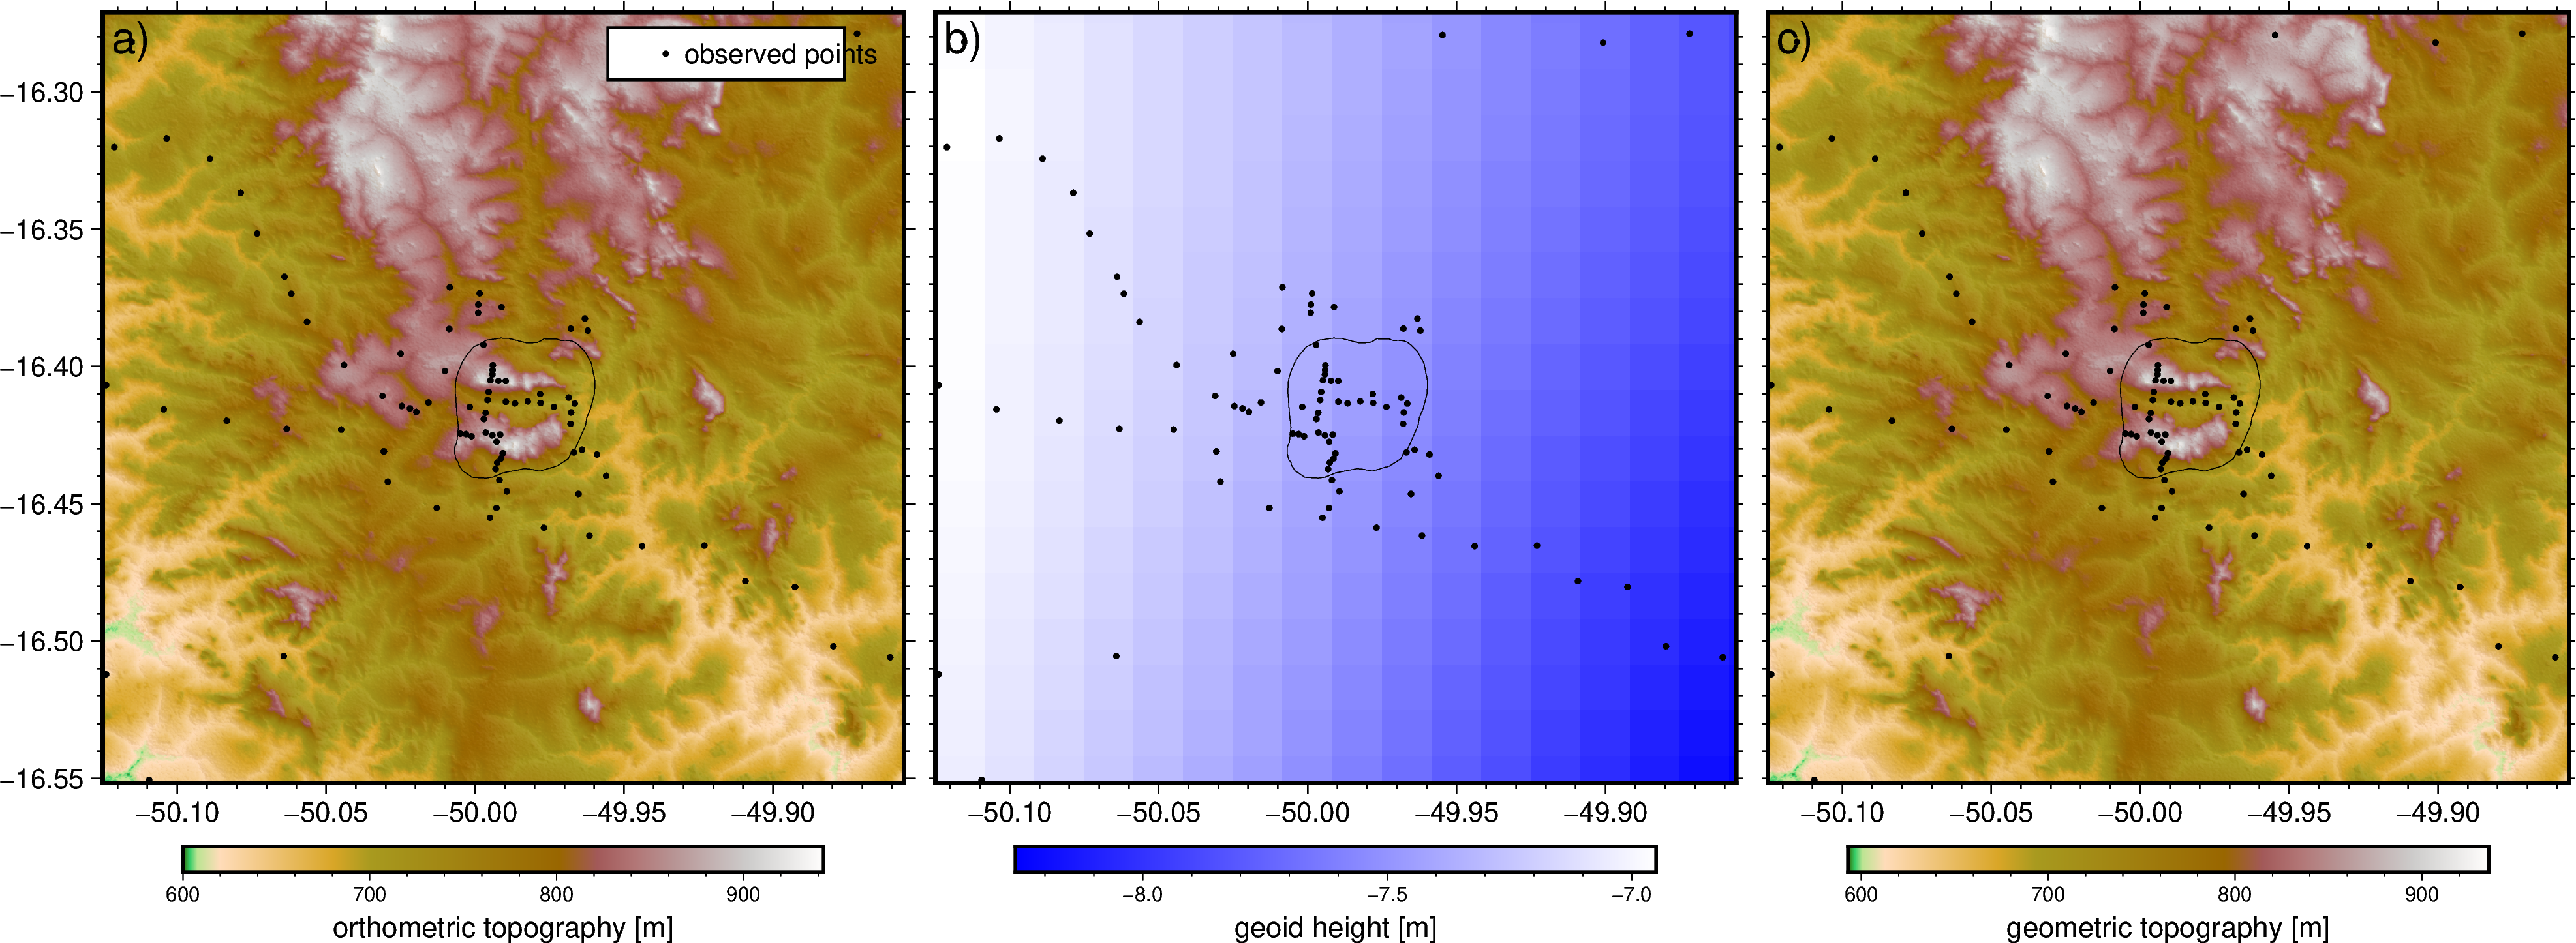

In [66]:
with plt.rc_context(mpl_rc):
    fig = pygmt.Figure()
    # pygmt.config(FORMAT_GEO_MAP="ddd.xx")
    with fig.subplot(
        nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.05c"
    ):
        with fig.set_panel(panel=0):
            
            fig.grdimage(topography, projection="X", cmap="etopo1", frame=["WSne", "xaf", "yaf"],
                        shading="+a45+nt0.15")# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
            fig.colorbar(frame='af+l"orthometric topography [m]"')
            fig.plot(
                        x=data.Longitude,
                        y=data.Latitude,
                        style="c0.08c",
                        color="black",
                        label='observed points'
                    )
            fig.plot(data=pluton, projection='M')
            fig.legend()
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
    
        with fig.set_panel(panel=1):
            fig.grdimage(geoid, projection="X", cmap="polar+h", frame=["WSne", "xaf", "f"])
            fig.colorbar(frame='af+l"geoid height [m]"')
            fig.plot(
                        x=data.Longitude,
                        y=data.Latitude,
                        style="c0.08c",
                        color="black",
                    )
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
        with fig.set_panel(panel=2):
            fig.grdimage(topography_geometric, projection="X", cmap="etopo1", frame=["WSne", "xaf", "f"],
                        shading="+a45+nt0.15")
            fig.colorbar(frame='af+l"geometric topography [m]"')
            fig.plot(
                        x=data.Longitude,
                        y=data.Latitude,
                        style="c0.08c",
                        color="black",
                    )
            fig.plot(data=pluton, projection='M')

fig.savefig(image_dir / 'heights.png', dpi=300)
fig.show()


In [67]:
geoid_table = vd.grid_to_table(geoid)
interpolator = vd.KNeighbors()
interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.scalars)
data = data.assign(geoid_m=interpolator.predict((data.Longitude, data.Latitude)))
data = data.assign(height_geometric_m=data.Elevation + data.geoid_m)
# data
# geoid_table

## Distúrbio da gravidade

In [68]:
data = data.assign(
    normal_gravity_mgal=bl.WGS84.normal_gravity(data.Latitude, data.height_geometric_m)
)
data = data.assign(gravity_disturbance_mgal=data.Gravity - data.normal_gravity_mgal)
data.head()

Latitude  Longitude    Gravity  Elevation Station  geoid_m  \
0 -16.660800 -50.133900  978284.00     617.79   L4102    -7.03   
1 -16.661389 -50.134444  978284.01     617.79   L4105    -7.03   
2 -16.592378 -50.256156  978276.07     664.37   L4105    -6.58   
3 -16.597542 -50.208025  978284.37     618.17   L4105    -6.75   
4 -16.601842 -50.166364  978287.16     603.99   L4105    -6.87   

   height_geometric_m  normal_gravity_mgal  gravity_disturbance_mgal  
0              610.76        978268.550218                 15.449782  
1              610.76        978268.579398                 15.430602  
2              657.79        978250.650814                 25.419186  
3              611.42        978265.217930                 19.152070  
4              597.12        978269.844045                 17.315955

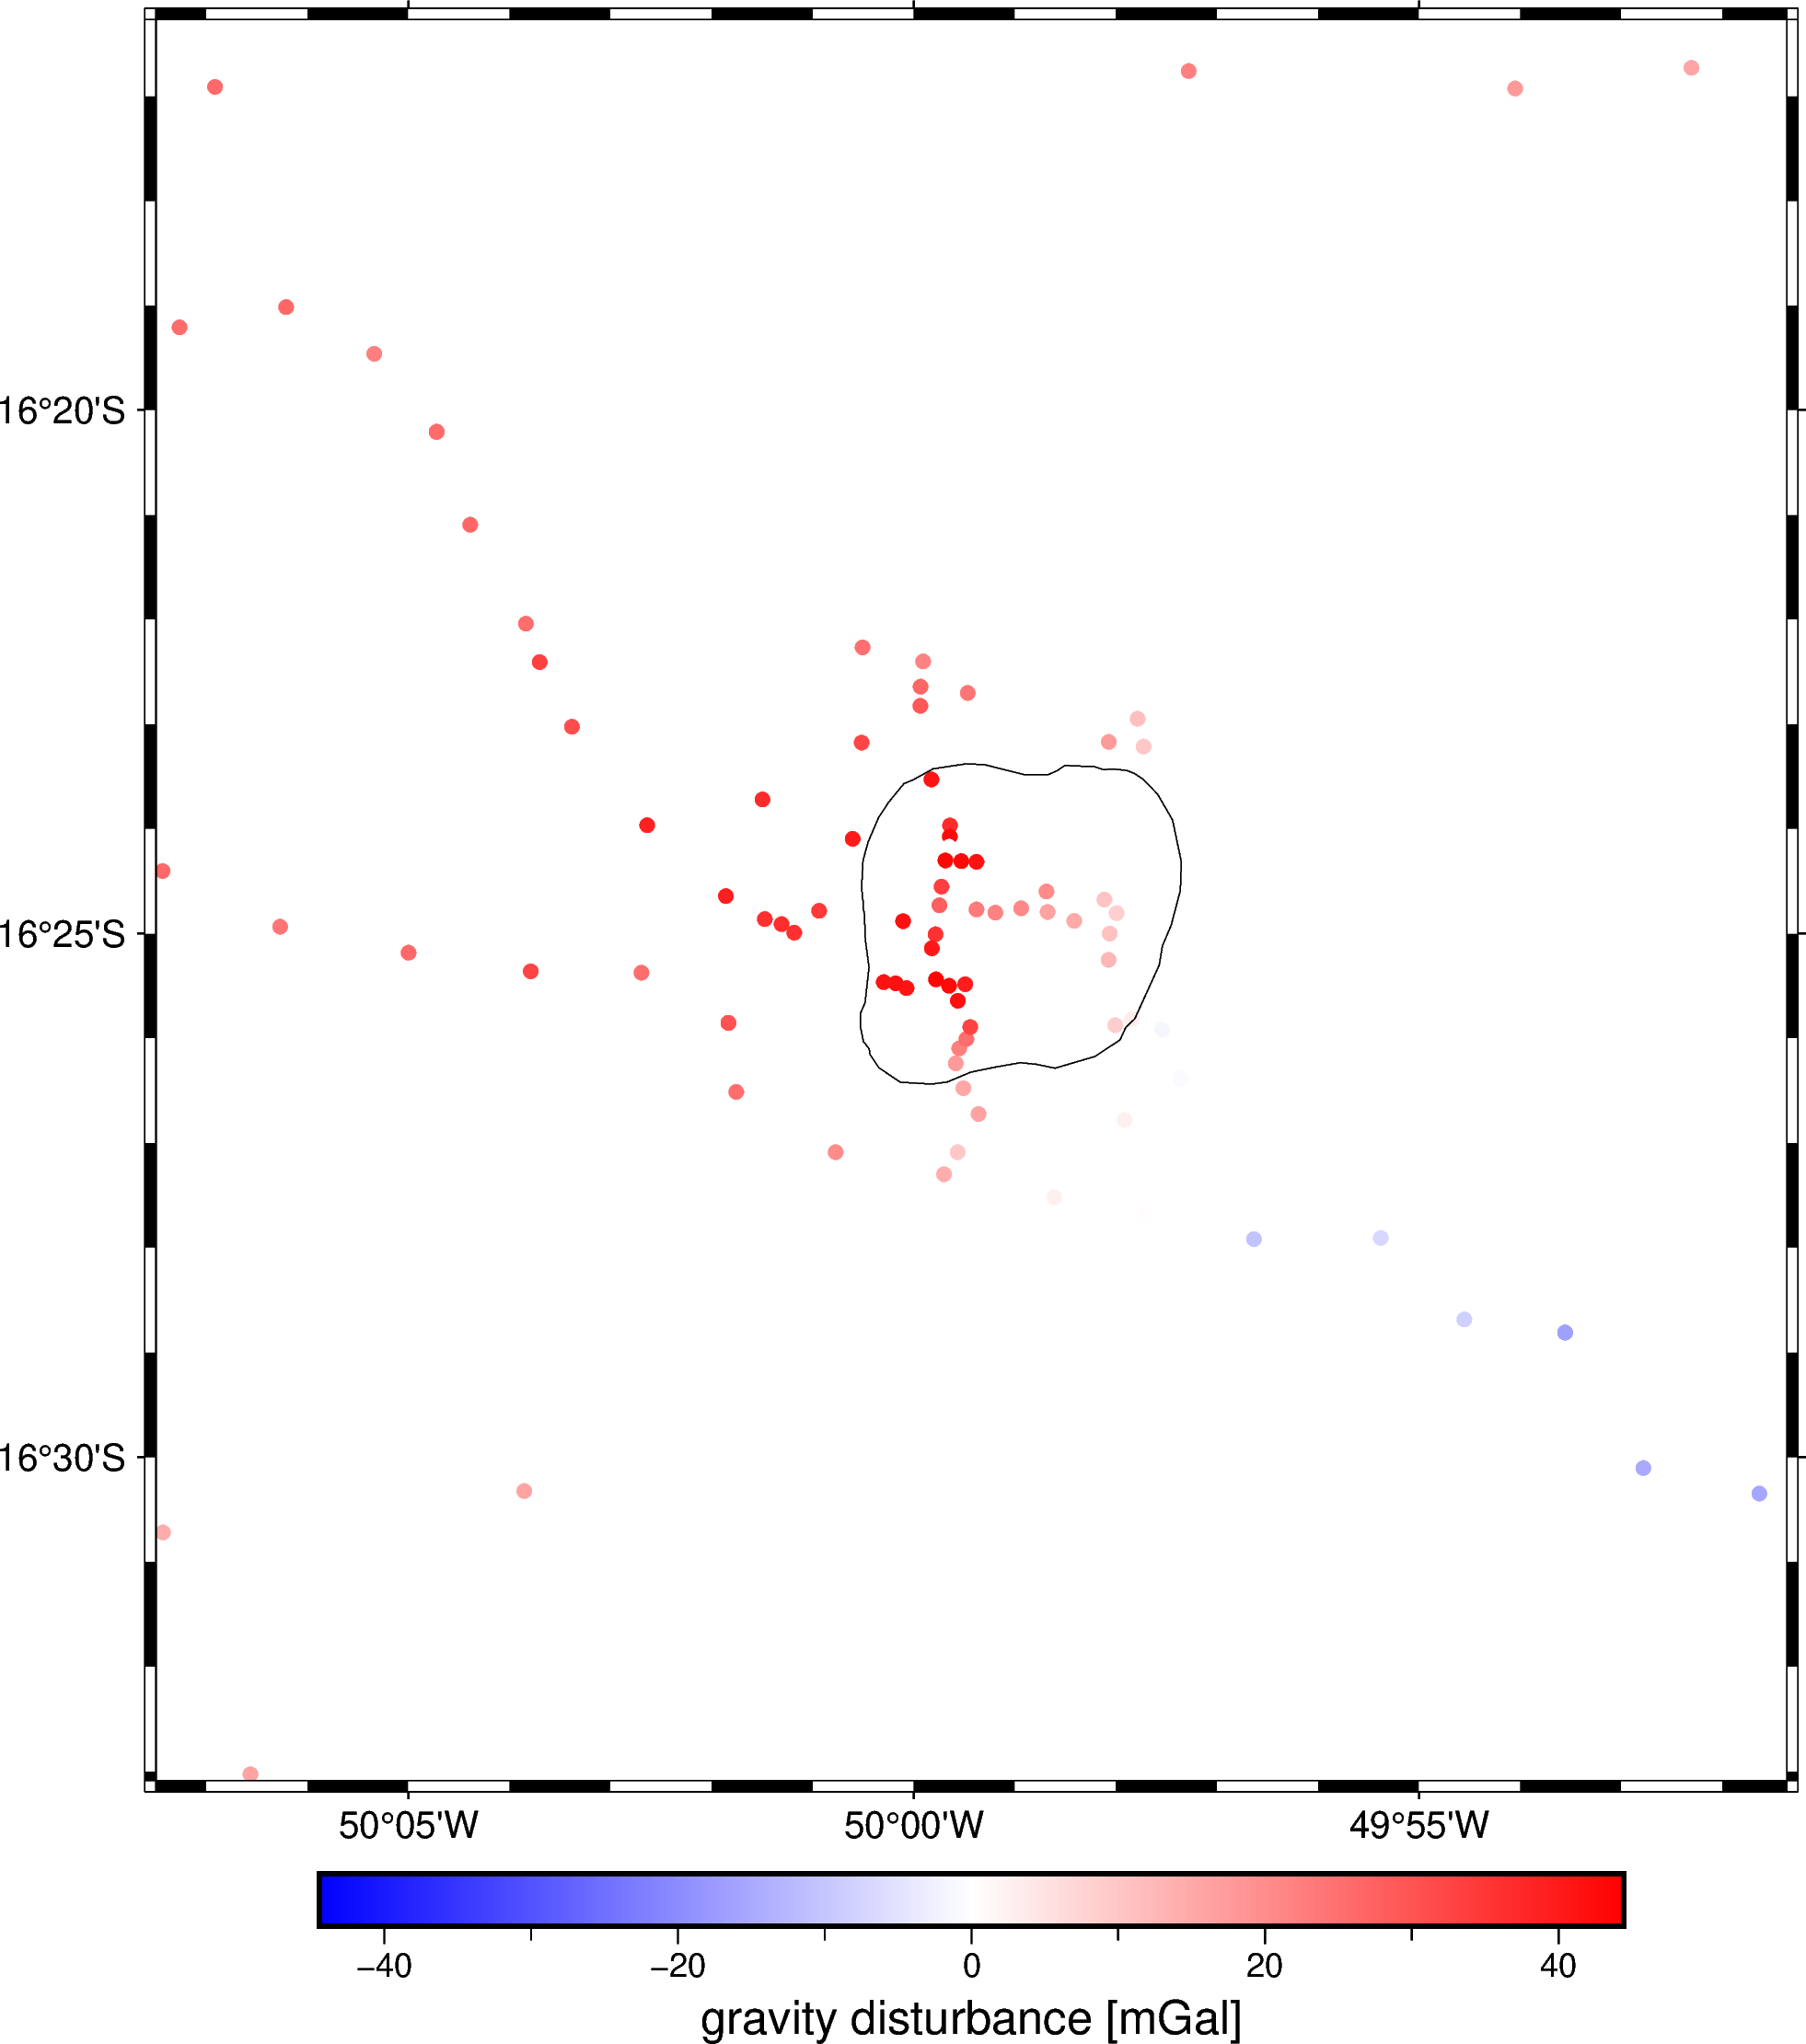

In [69]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_disturbance_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    color=data.gravity_disturbance_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame="af",
)
fig.plot(data=pluton, projection='M')
fig.colorbar(frame='af+l"gravity disturbance [mGal]"')
fig.show(width=600)

image

<!-- ## Correção topográfica -->

<!-- ![](https://www.fatiando.org/tutorials/_images/topographic-correction.svg) -->

In [70]:
# projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
projection = pyproj.Proj(proj='utm', ellps='WGS84', zone=22, south=True)

In [71]:
easting, northing = projection(data.Longitude.values, data.Latitude.values)
data = data.assign(easting_m=easting, northing_m=northing)
data.head(5)

Latitude  Longitude    Gravity  Elevation Station  geoid_m  \
0 -16.660800 -50.133900  978284.00     617.79   L4102    -7.03   
1 -16.661389 -50.134444  978284.01     617.79   L4105    -7.03   
2 -16.592378 -50.256156  978276.07     664.37   L4105    -6.58   
3 -16.597542 -50.208025  978284.37     618.17   L4105    -6.75   
4 -16.601842 -50.166364  978287.16     603.99   L4105    -6.87   

   height_geometric_m  normal_gravity_mgal  gravity_disturbance_mgal  \
0              610.76        978268.550218                 15.449782   
1              610.76        978268.579398                 15.430602   
2              657.79        978250.650814                 25.419186   
3              611.42        978265.217930                 19.152070   
4              597.12        978269.844045                 17.315955   

       easting_m    northing_m  
0  592357.677014  8.157768e+06  
1  592299.380910  8.157703e+06  
2  579348.205892  8.165390e+06  
3  584480.504463  8.164799e+06  
4  588922.791399  8.164305e+06

In [72]:
topography_proj = vd.project_grid(topography_geometric, projection, method="nearest")
# topography_proj.plot()

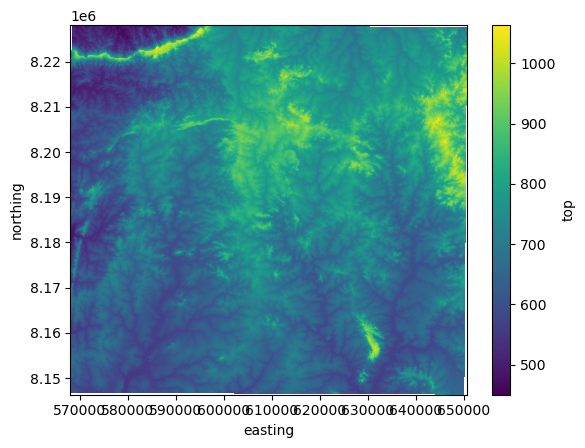

In [73]:
topography_density = np.where(topography_proj > 0, 2670, 1040 - 2670)
topography_model = hm.prism_layer(
    coordinates=(topography_proj.easting, topography_proj.northing),
    surface=topography_proj,
    reference=0,
    properties={"density": topography_density}
)

topography_model.top.plot()

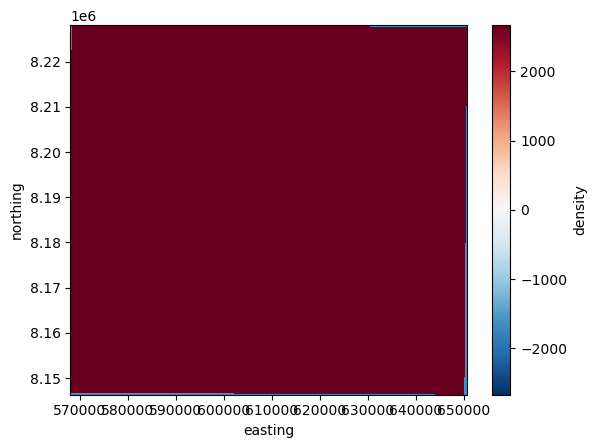

In [74]:
# fig = pygmt.Figure()
# scale = vd.maxabs(topography_model.density)
# pygmt.makecpt(cmap="roma+h", reverse=True, series=[-scale, scale])
# fig.grdimage(topography_model.density, projection="X15c/15c", frame=True)
# fig.colorbar(frame='af+l"Density of the prism model [kg/m3]"')
# fig.show()

topography_model.density.plot()

In [75]:
coordinates = (data.easting_m, data.northing_m, data.height_geometric_m)
terrain_effect = topography_model.prism_layer.gravity(coordinates, field="g_z")

In [76]:
data = data.assign(
    gravity_bouguer_mgal=data.gravity_disturbance_mgal - terrain_effect
)
data.head()

Latitude  Longitude    Gravity  Elevation Station  geoid_m  \
0 -16.660800 -50.133900  978284.00     617.79   L4102    -7.03   
1 -16.661389 -50.134444  978284.01     617.79   L4105    -7.03   
2 -16.592378 -50.256156  978276.07     664.37   L4105    -6.58   
3 -16.597542 -50.208025  978284.37     618.17   L4105    -6.75   
4 -16.601842 -50.166364  978287.16     603.99   L4105    -6.87   

   height_geometric_m  normal_gravity_mgal  gravity_disturbance_mgal  \
0              610.76        978268.550218                 15.449782   
1              610.76        978268.579398                 15.430602   
2              657.79        978250.650814                 25.419186   
3              611.42        978265.217930                 19.152070   
4              597.12        978269.844045                 17.315955   

       easting_m    northing_m  gravity_bouguer_mgal  
0  592357.677014  8.157768e+06            -51.557407  
1  592299.380910  8.157703e+06            -51.774664  
2  579348.205892  8.165390e+06            -46.753156  
3  584480.504463  8.164799e+06            -48.030052  
4  588922.791399  8.164305e+06            -48.397597

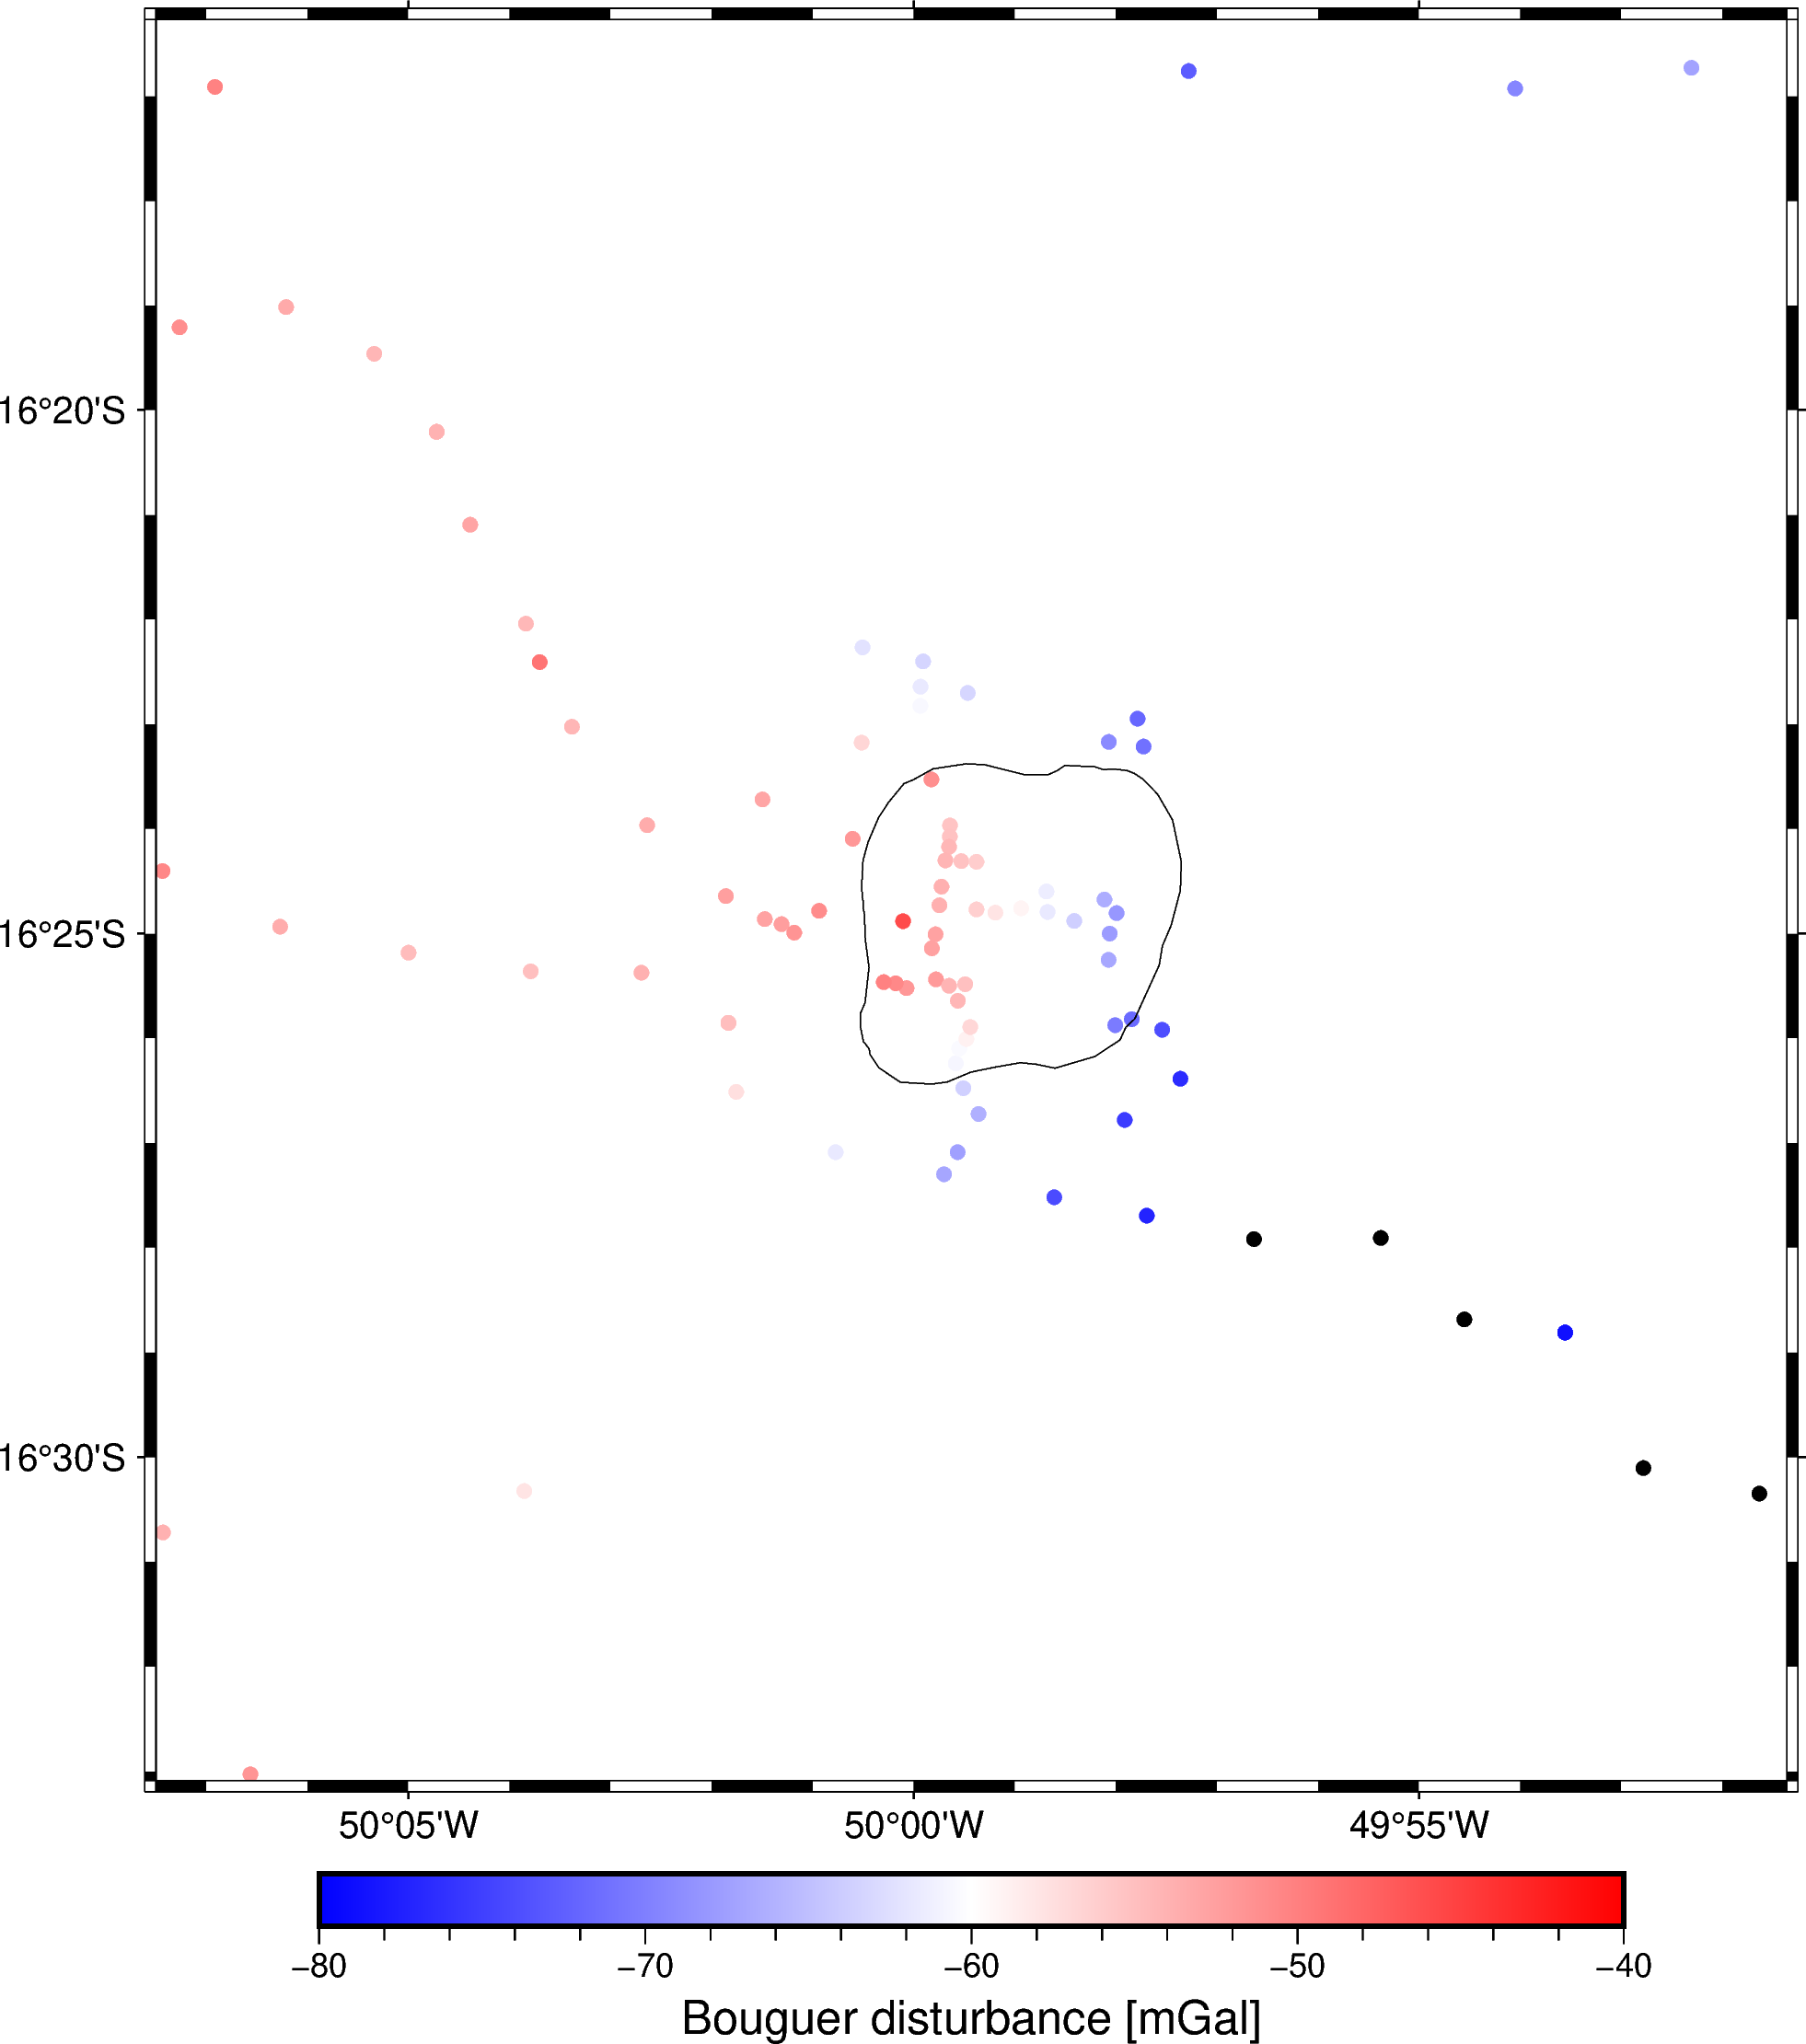

In [77]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_bouguer_mgal)
pygmt.makecpt(cmap="polar", series=[-80, -40])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    color=data.gravity_bouguer_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
fig.plot(data=pluton, projection='M')
fig.show()

## Separação regional residual

In [78]:
regional = vd.Trend(degree=1).fit(coordinates, data.gravity_bouguer_mgal)
# regional = hm.upward_continuation()

data = data.assign(
    regional_mgal=regional.predict(coordinates),
)
data = data.assign(
    residual_mgal=data.gravity_bouguer_mgal - data.regional_mgal,
)
data.head()

Latitude  Longitude    Gravity  Elevation Station  geoid_m  \
0 -16.660800 -50.133900  978284.00     617.79   L4102    -7.03   
1 -16.661389 -50.134444  978284.01     617.79   L4105    -7.03   
2 -16.592378 -50.256156  978276.07     664.37   L4105    -6.58   
3 -16.597542 -50.208025  978284.37     618.17   L4105    -6.75   
4 -16.601842 -50.166364  978287.16     603.99   L4105    -6.87   

   height_geometric_m  normal_gravity_mgal  gravity_disturbance_mgal  \
0              610.76        978268.550218                 15.449782   
1              610.76        978268.579398                 15.430602   
2              657.79        978250.650814                 25.419186   
3              611.42        978265.217930                 19.152070   
4              597.12        978269.844045                 17.315955   

       easting_m    northing_m  gravity_bouguer_mgal  regional_mgal  \
0  592357.677014  8.157768e+06            -51.557407     -54.443077   
1  592299.380910  8.157703e+06            -51.774664     -54.399656   
2  579348.205892  8.165390e+06            -46.753156     -42.873643   
3  584480.504463  8.164799e+06            -48.030052     -47.232434   
4  588922.791399  8.164305e+06            -48.397597     -51.003697   

   residual_mgal  
0       2.885670  
1       2.624992  
2      -3.879513  
3      -0.797618  
4       2.606100

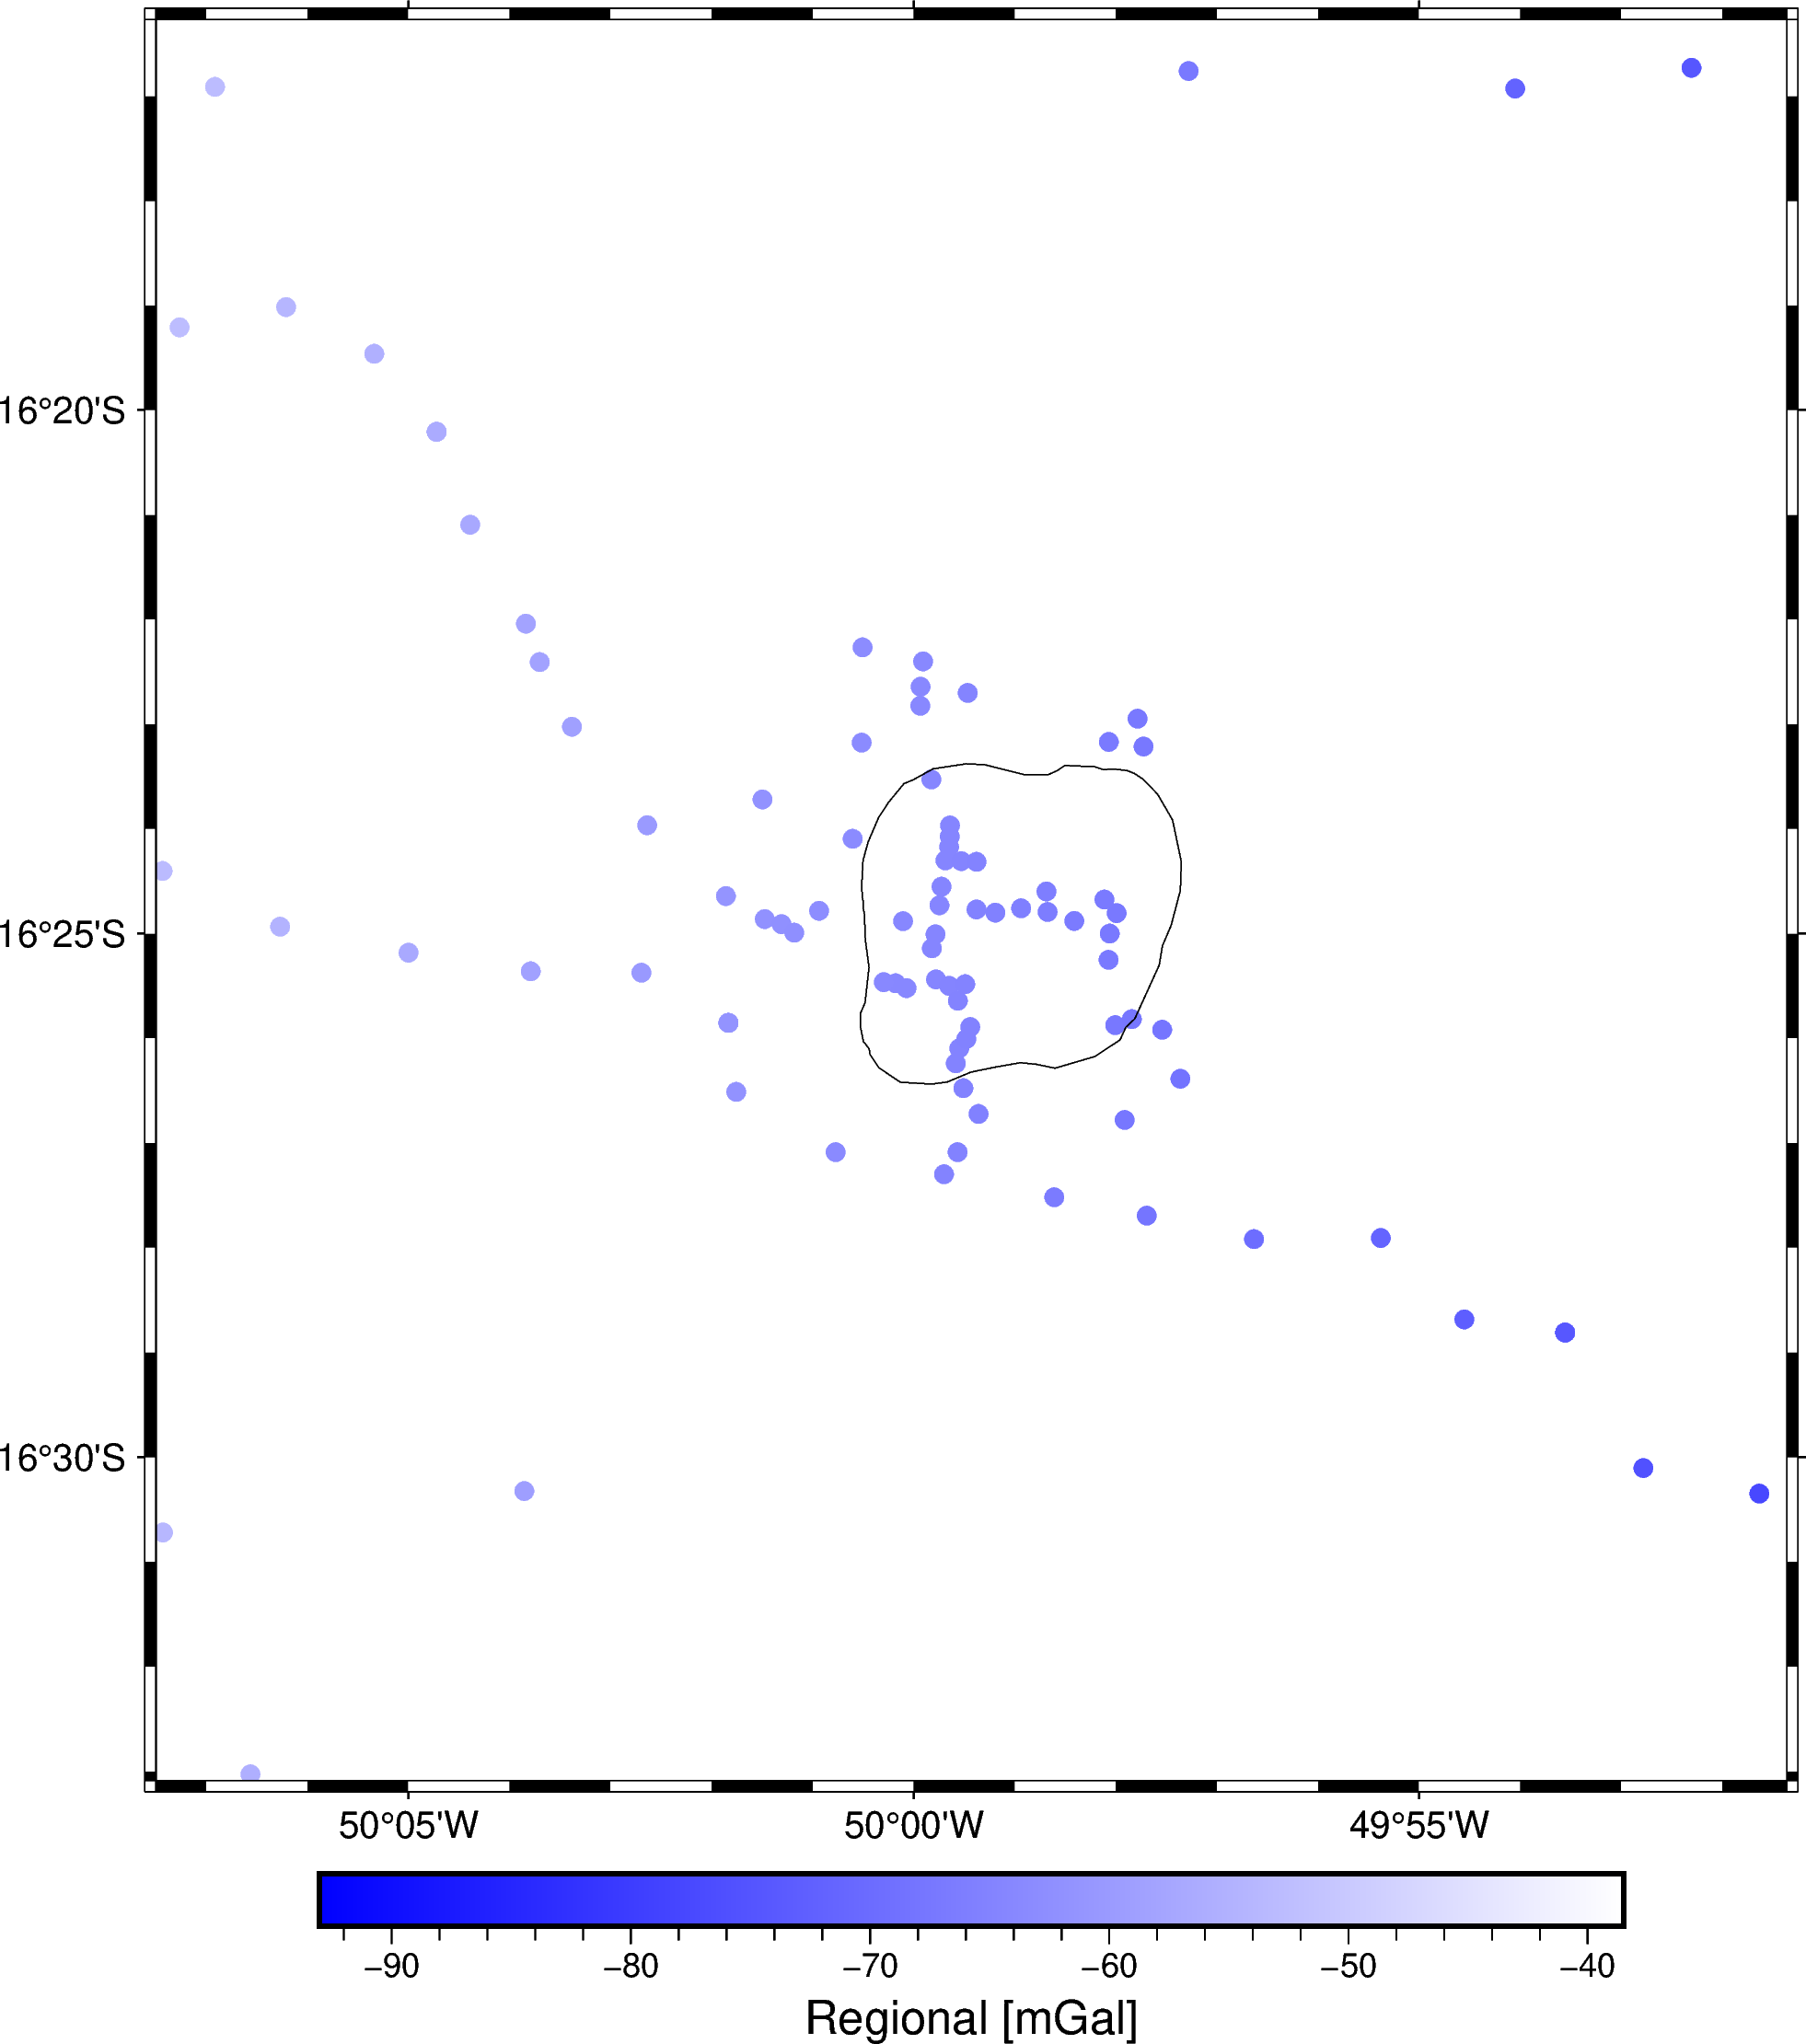

In [79]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.regional_mgal)
pygmt.makecpt(cmap="polar+h", series=[data.regional_mgal.min(), data.regional_mgal.max()])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    color=data.regional_mgal,
    cmap=True,
    style="c5p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Regional [mGal]"')
fig.plot(data=pluton, projection='M')
fig.show()

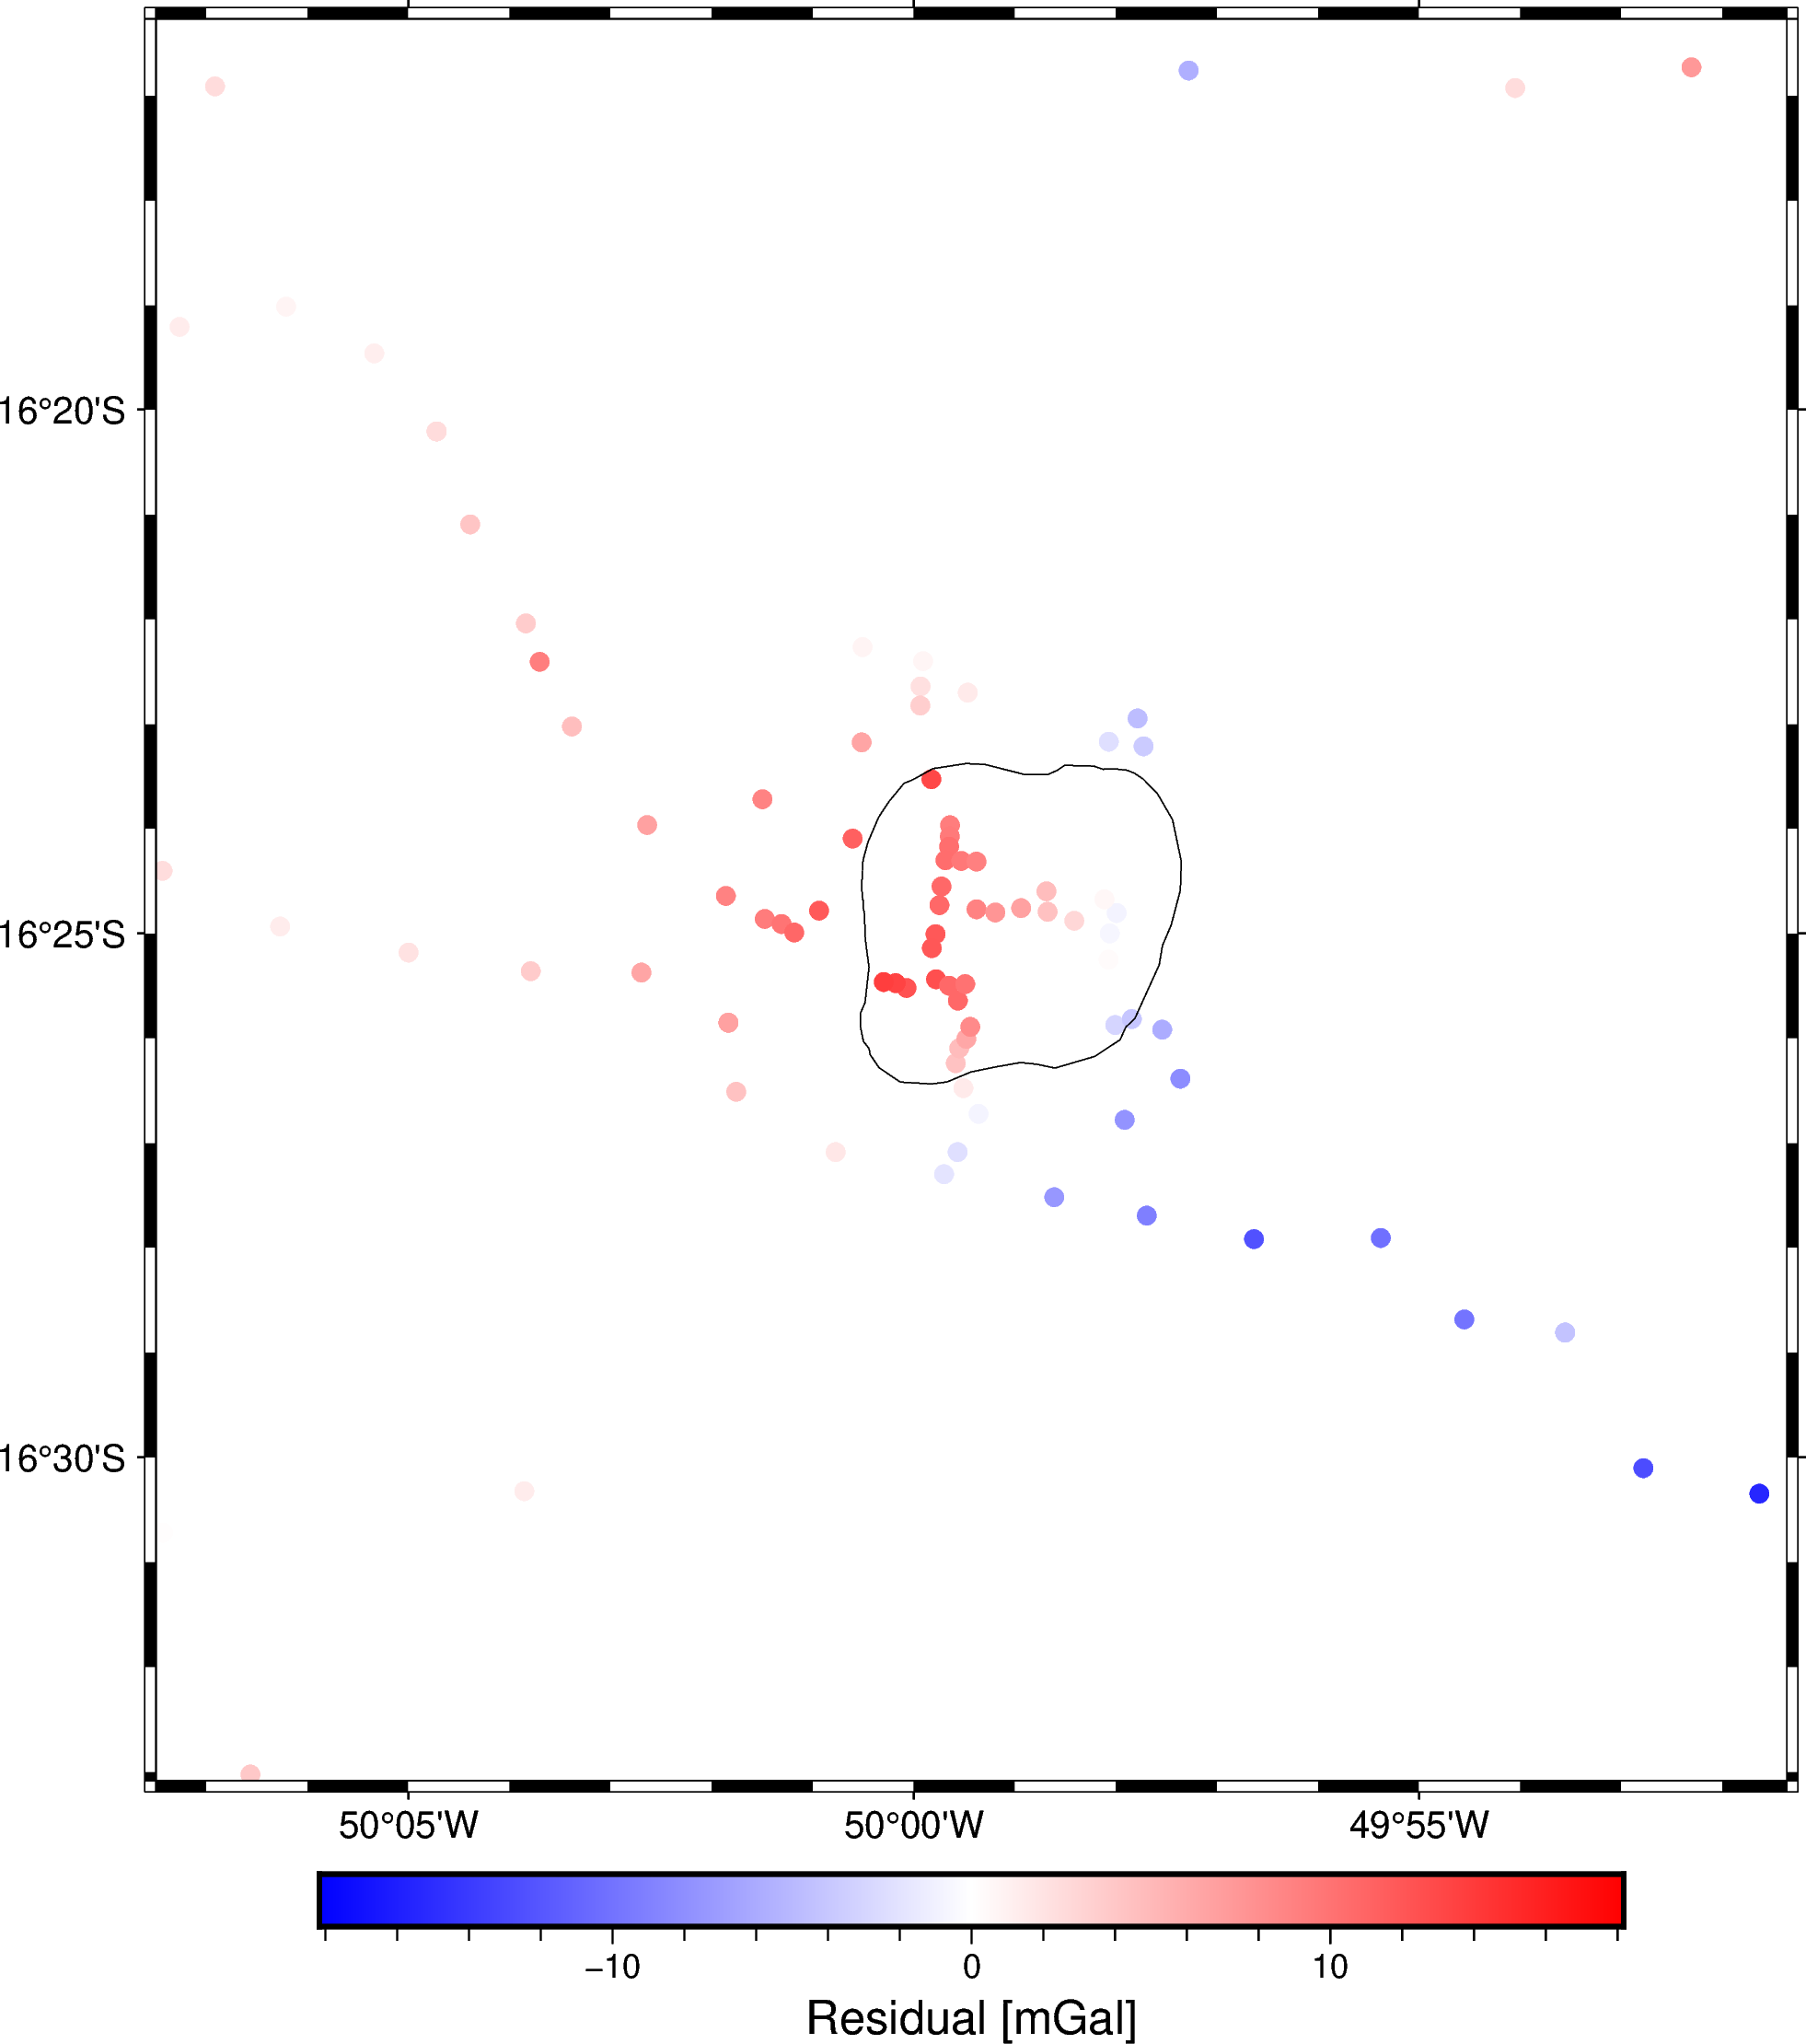

In [80]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.residual_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    color=data.residual_mgal,
    cmap=True,
    style="c5p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Residual [mGal]"')
fig.plot(data=pluton, projection='M')
fig.show()

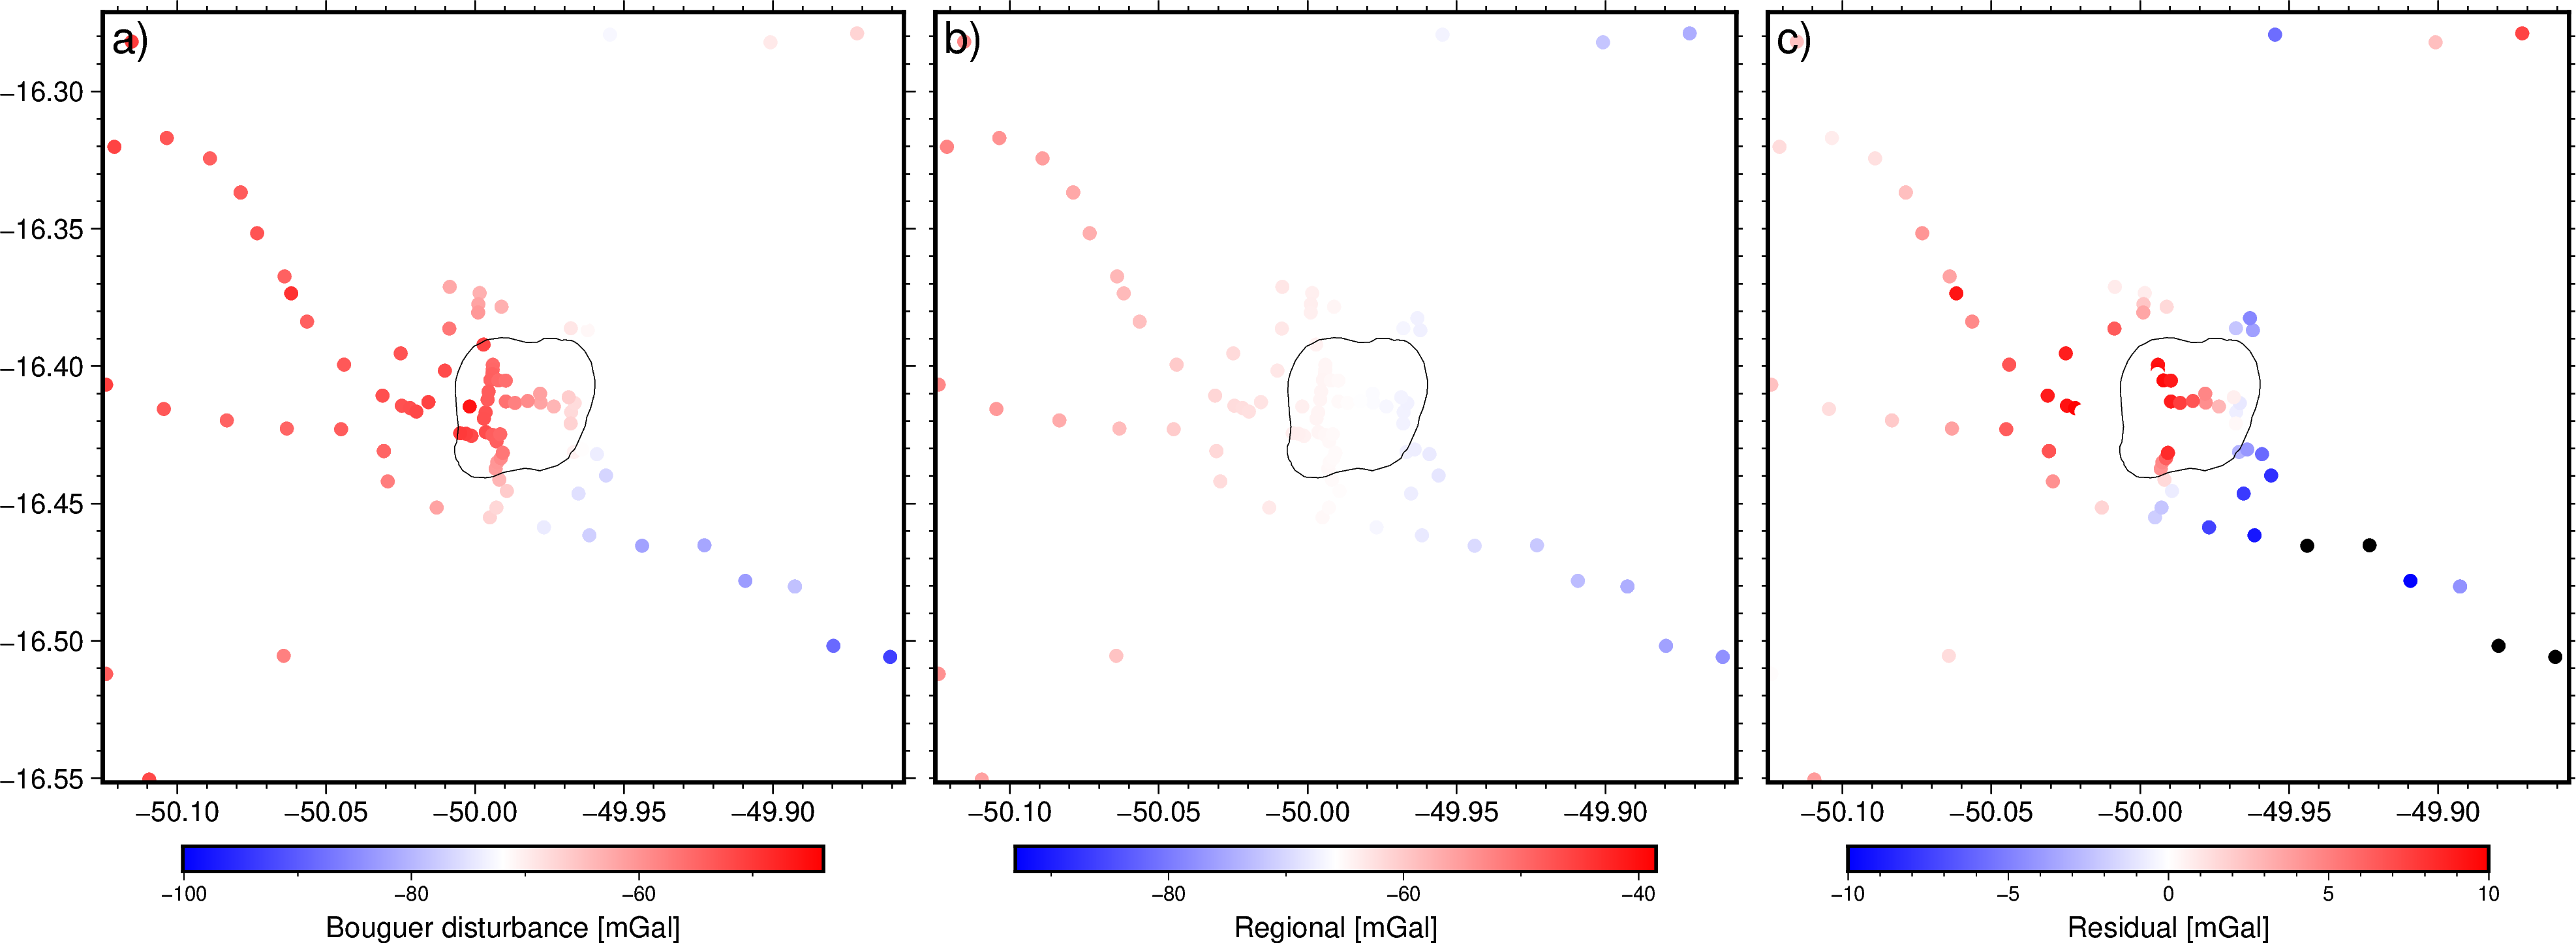

In [81]:
with plt.rc_context(mpl_rc):
    fig = pygmt.Figure()
    # fig.subplot(nrows=1, ncols=3, figsize=("15c", "5c"), frame="a")
    with fig.subplot(
        nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.05c"
    ):
        with fig.set_panel(panel=0):
            maxabs = vd.maxabs(data.gravity_bouguer_mgal)
            pygmt.makecpt(cmap="polar", series=[data.gravity_bouguer_mgal.min(), data.gravity_bouguer_mgal.max()])
            fig.plot(
                x=data.Longitude,
                y=data.Latitude,
                color=data.gravity_bouguer_mgal,
                cmap=True,
                style="c5p",
                projection="X",
                frame=["WSne", "xaf", "yaf"],
            )
            fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
        with fig.set_panel(panel=1):
            maxabs = vd.maxabs(data.regional_mgal)
            pygmt.makecpt(cmap="polar", series=[data.regional_mgal.min(), data.regional_mgal.max()])
            fig.plot(
                x=data.Longitude,
                y=data.Latitude,
                color=data.regional_mgal,
                cmap=True,
                style="c5p",
                projection="X",
                frame=["WSne", "xaf", "f"],
            )
            fig.colorbar(frame='af+l"Regional [mGal]"')
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
        with fig.set_panel(panel=2):
            maxabs = vd.maxabs(data.residual_mgal)
            pygmt.makecpt(cmap="polar", series=[-10, 10])
            fig.plot(
                x=data.Longitude,
                y=data.Latitude,
                color=data.residual_mgal,
                cmap=True,
                style="c5p",
                projection="X",
                frame=["WSne", "xaf", "f"],
            )
            fig.colorbar(frame='af+l"Residual [mGal]"')
            
            fig.plot(data=pluton, projection='M')
            # fig.basemap(map_scale="n0.9/0.06+w5k+u")


fig.savefig(image_dir/'gravity.png', dpi=300)
fig.show()


## Interpolação com fontes equivalentes

In [92]:
# eqs = hm.EquivalentSources(damping=1.0, depth=4.5e3)
# eqs.fit((data.easting_m, data.northing_m, data.height_geometric_m),  data.residual_mgal) # data.gravity_bouguer_mgal)

eqs = hm.EquivalentSources(damping=1.0, depth=8e3)
eqs.fit((data.easting_m, data.northing_m, data.height_geometric_m), data.gravity_bouguer_mgal)# data.residual_mgal)

EquivalentSources(damping=1.0, depth=8000.0)

In [93]:
# Interpolar extra coord a partir da topografia
region_pad_2 = vd.pad_region(region, pad=+0.05)
grid_extra_coord = vd.grid_coordinates(region_pad_2, spacing= 2 / 3600)

interpolator = vd.KNeighbors()
topography_table = vd.grid_to_table(topography)
interpolator.fit((topography_table.longitude, topography_table.latitude), topography_table.elevation)
extra_coord=interpolator.predict((grid_extra_coord[0], grid_extra_coord[1]))

# geoid_values = np.reshape(geoid_1.elevation, topography.shape)
coordinates_grid = ([grid_extra_coord[0], grid_extra_coord[1], extra_coord])

In [94]:
residual_grid = eqs.grid(
    # coordinates=vd.grid_coordinates(region_pad_2, spacing=2 / 3600, extra_coords=1.0e3),
    coordinates=coordinates_grid,
    data_names="gravity_residual",
    dims=("latitude", "longitude"),
    projection=projection,
)
residual_grid

<xarray.Dataset> Size: 17MB
Dimensions:           (latitude: 1145, longitude: 1208)
Coordinates:
  * longitude         (longitude) float64 10kB -50.31 -50.31 ... -49.64 -49.64
  * latitude          (latitude) float64 9kB -16.71 -16.71 ... -16.08 -16.08
    upward            (latitude, longitude) float32 6MB 636.0 636.0 ... 775.0
Data variables:
    gravity_residual  (latitude, longitude) float64 11MB -35.22 ... -39.43
Attributes:
    metadata:  Generated by EquivalentSources(damping=1.0, depth=8000.0)

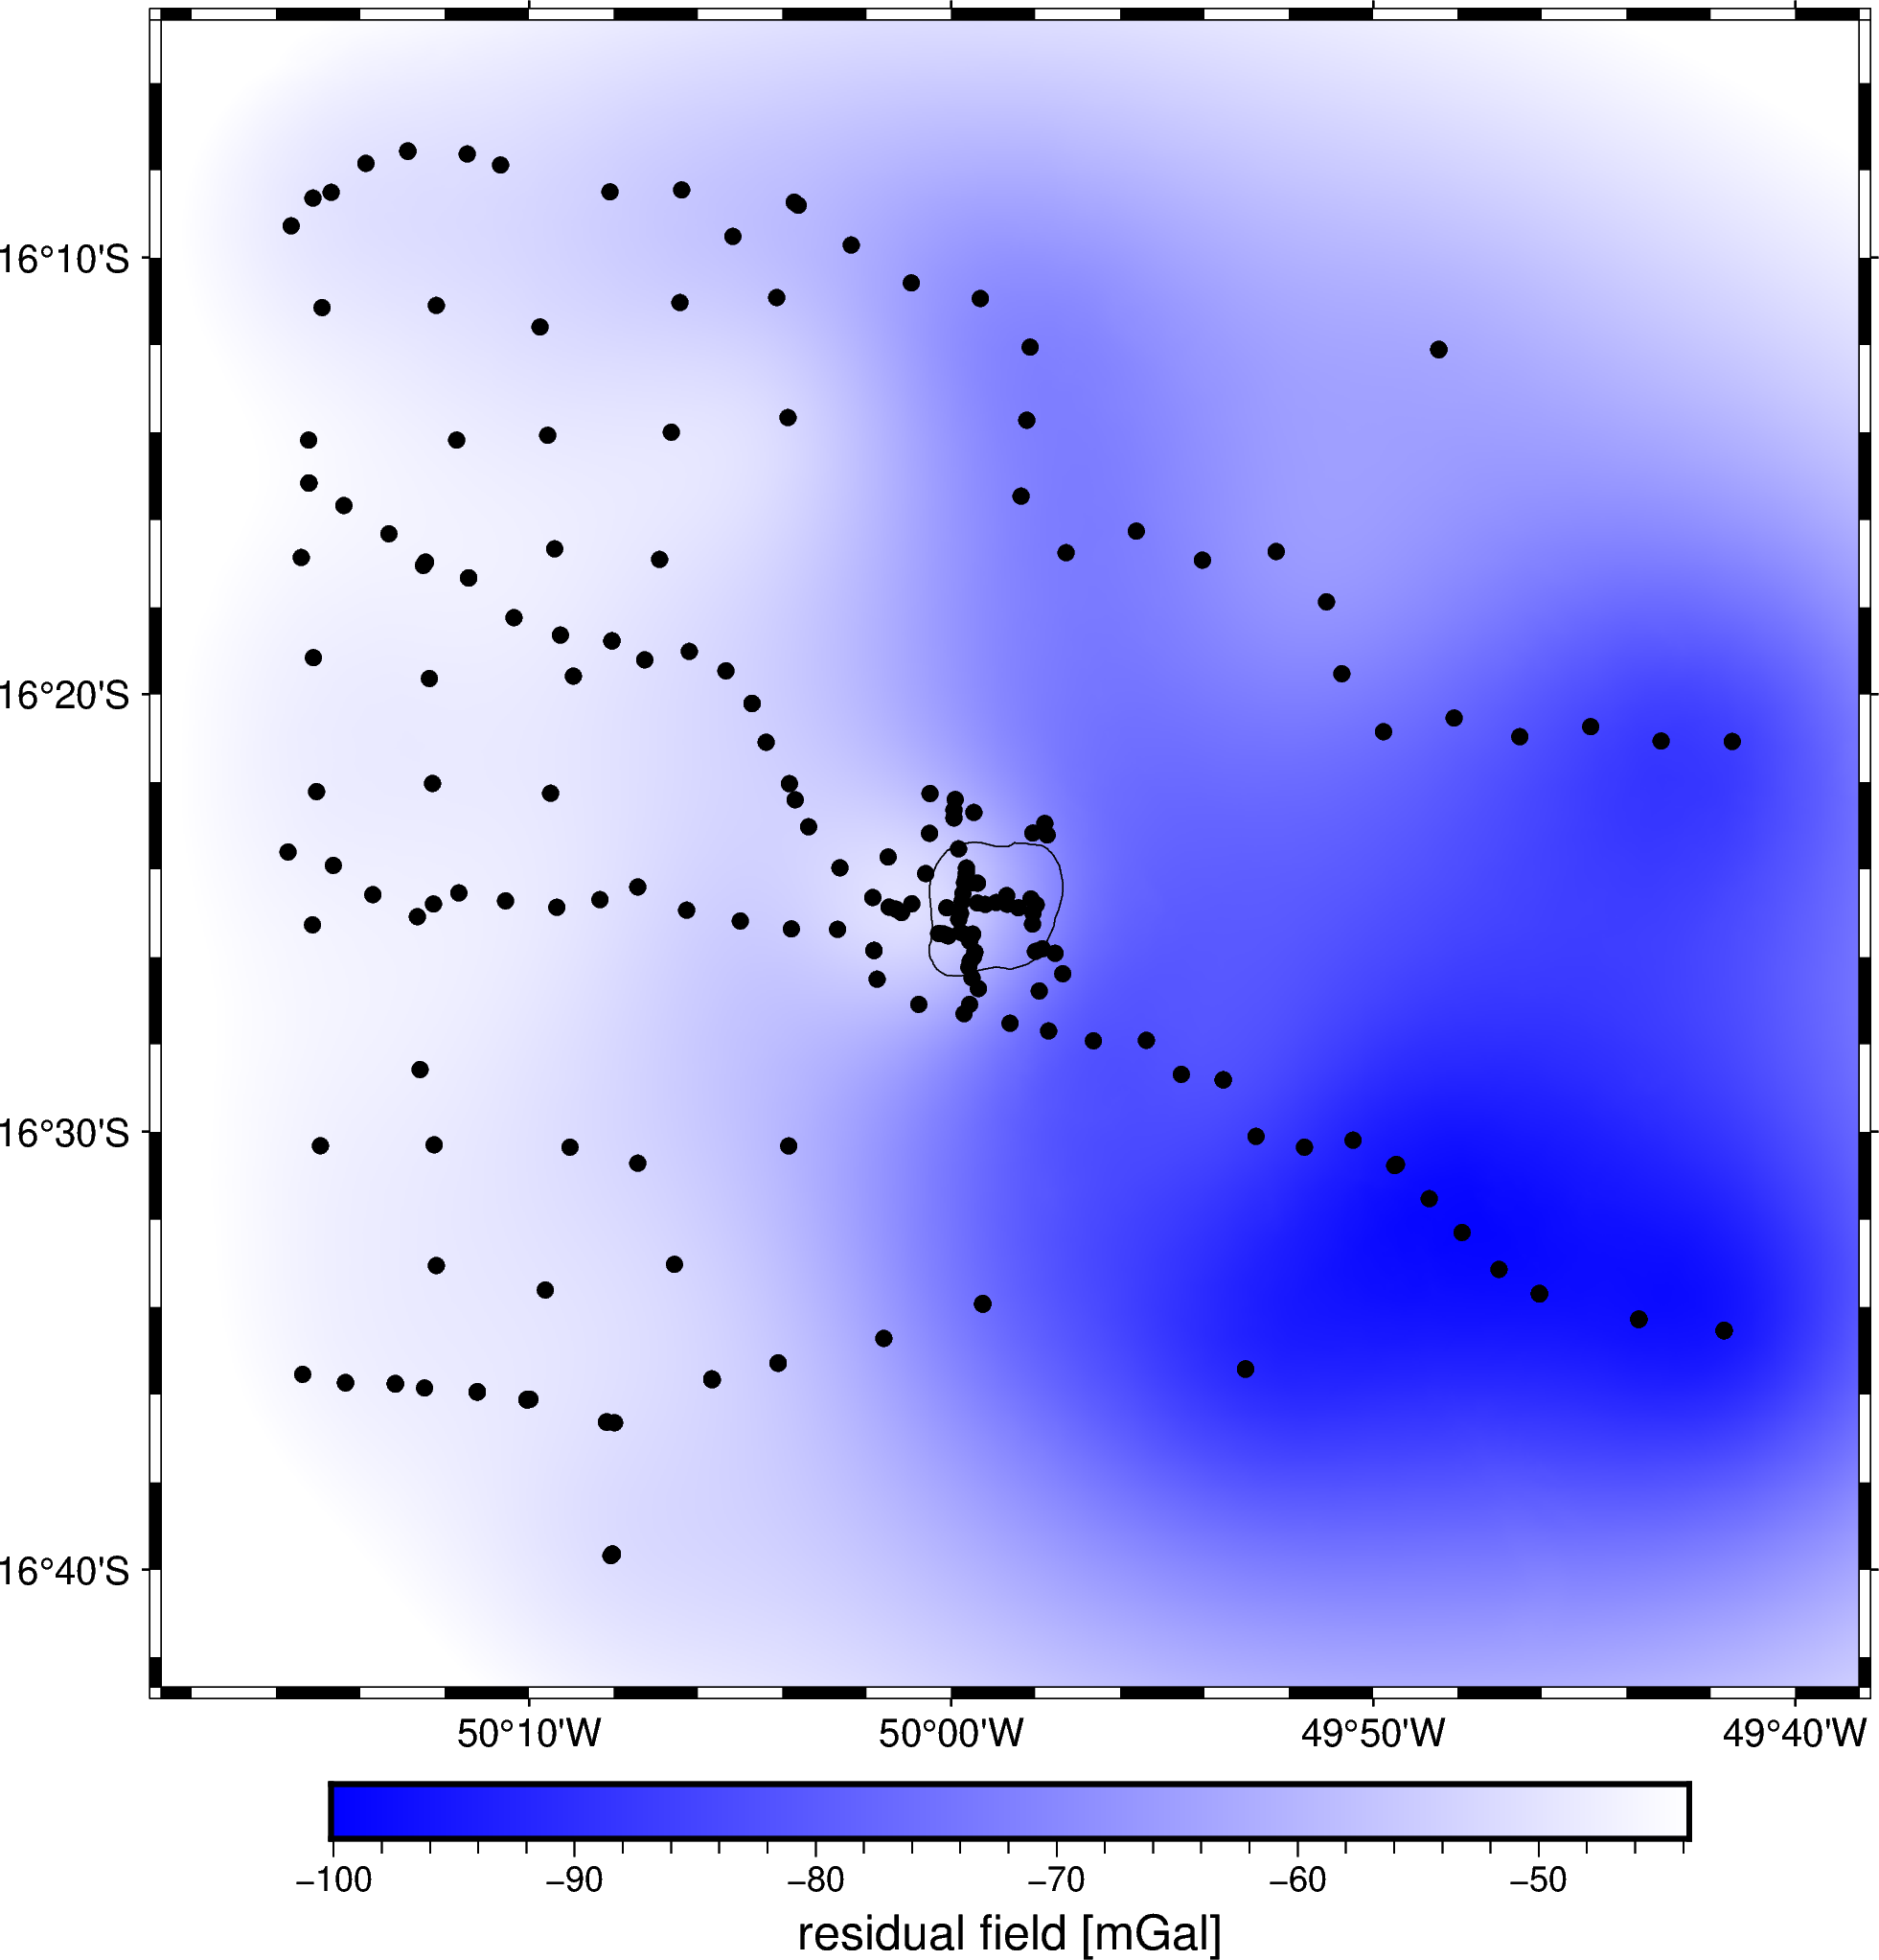

In [95]:
fig = pygmt.Figure()
scale_max = data.gravity_bouguer_mgal.values.max()#vd.maxabs(residual_grid.gravity_residual)
scale_min = data.gravity_bouguer_mgal.values.min()
# scale_max = data.residual_mgal.values.max()
# scale_min = data.residual_mgal.values.min()
pygmt.makecpt(cmap="polar+h", series=[scale_min, scale_max], no_bg=True)
# pygmt.makecpt(cmap="polar+h", series=[-85, -40], no_bg=True)
fig.grdimage(
    residual_grid.gravity_residual,
    # shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
    region=vd.pad_region(region, pad=0.05)
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.15c",
    color="black",
)
fig.plot(data=pluton, projection='M')
 
fig.show()

In [96]:
# ## Validação cruzada entre dados de grav residual e camada equivalente
# r2_score = np.mean(
#     vd.cross_val_score(
#         eqs,
#         coordinates,
#         data.residual_mgal,
#     )
# )
# print(f'O R² do modelo de camada equivalente para os dados é de: {r2_score:.3f}')

# Validação cruzada entre dados de grav residual e camada equivalente
r2_score = np.mean(
    vd.cross_val_score(
        eqs,
        coordinates,
        data.gravity_bouguer_mgal,
    )
)
print(f'O R² do modelo de camada equivalente para os dados é de: {r2_score:.3f}')

O R² do modelo de camada equivalente para os dados é de: 0.979


In [36]:
residual_grid

<xarray.Dataset> Size: 1MB
Dimensions:           (latitude: 326, longitude: 305)
Coordinates:
  * longitude         (longitude) float64 2kB -50.07 -50.07 ... -49.91 -49.91
  * latitude          (latitude) float64 3kB -16.5 -16.5 -16.5 ... -16.32 -16.32
    upward            (latitude, longitude) float32 398kB 648.0 650.0 ... 797.0
Data variables:
    gravity_residual  (latitude, longitude) float64 795kB -2.748 ... -1.862
Attributes:
    metadata:  Generated by EquivalentSources(damping=1.0, depth=2500.0)

In [37]:
g_east, g_north = projection(*coordinates_grid[:2])
g_up = coordinates_grid[2]


# ds = xr.Dataset(
#     {
#         "gravity": (("y", "x"), residual_grid.gravity_residual.values),
#         # "upward": (("y", "x"), g_up)
#     },
#     coords={
#         "northing": (("y", "x"), g_north),
#         "easting": (("y", "x"), g_east),
#               "upward": (("y", "x"), g_up)
#     }
# )


# Defina os arrays x e y
x = g_east[0, :]   # assume que g_east é uma matriz com coordenadas na dimensão x
y = g_north[:, 0]  # assume que g_north é uma matriz com coordenadas na dimensão y

ds = xr.Dataset(
    {
        "gravity": (("y", "x"), residual_grid.gravity_residual.values),
    },
    coords={
        "easting": ("x", x),
        "northing": ("y", y),
        # "northing": (("y", "x"), g_north),
        # "easting": (("y", "x"), g_east),
        "upward": (("y", "x"), g_up)
    }
)


In [38]:
ds.gravity.min()
ds

<xarray.Dataset> Size: 1MB
Dimensions:   (y: 326, x: 305)
Coordinates:
    easting   (x) float64 2kB 5.987e+05 5.988e+05 ... 6.167e+05 6.168e+05
    northing  (y) float64 3kB 8.175e+06 8.175e+06 ... 8.195e+06 8.195e+06
    upward    (y, x) float32 398kB 648.0 650.0 649.0 653.0 ... 801.0 798.0 797.0
Dimensions without coordinates: y, x
Data variables:
    gravity   (y, x) float64 795kB -2.748 -2.758 -2.767 ... -1.874 -1.868 -1.862

In [39]:
# upward_cont = hm.upward_continuation(residual_grid.gravity_residual,  0.0815)
# upward_cont.min()

# residual_grid.gravity_residual.values = residual_grid.gravity_residual.values - upward_cont.values

upward_cont = hm.upward_continuation(ds.gravity,  0.008)
print(upward_cont.max())

# residual_grid.gravity_residual.values = residual_grid.gravity_residual.values - upward_cont.values

<xarray.DataArray ()> Size: 8B
array(5.66746692)


grdimage [WARNING]: Your grid y's or latitudes appear to be outside the map region and will be skipped.
grdimage [WARNING]: No grid or image inside plot domain


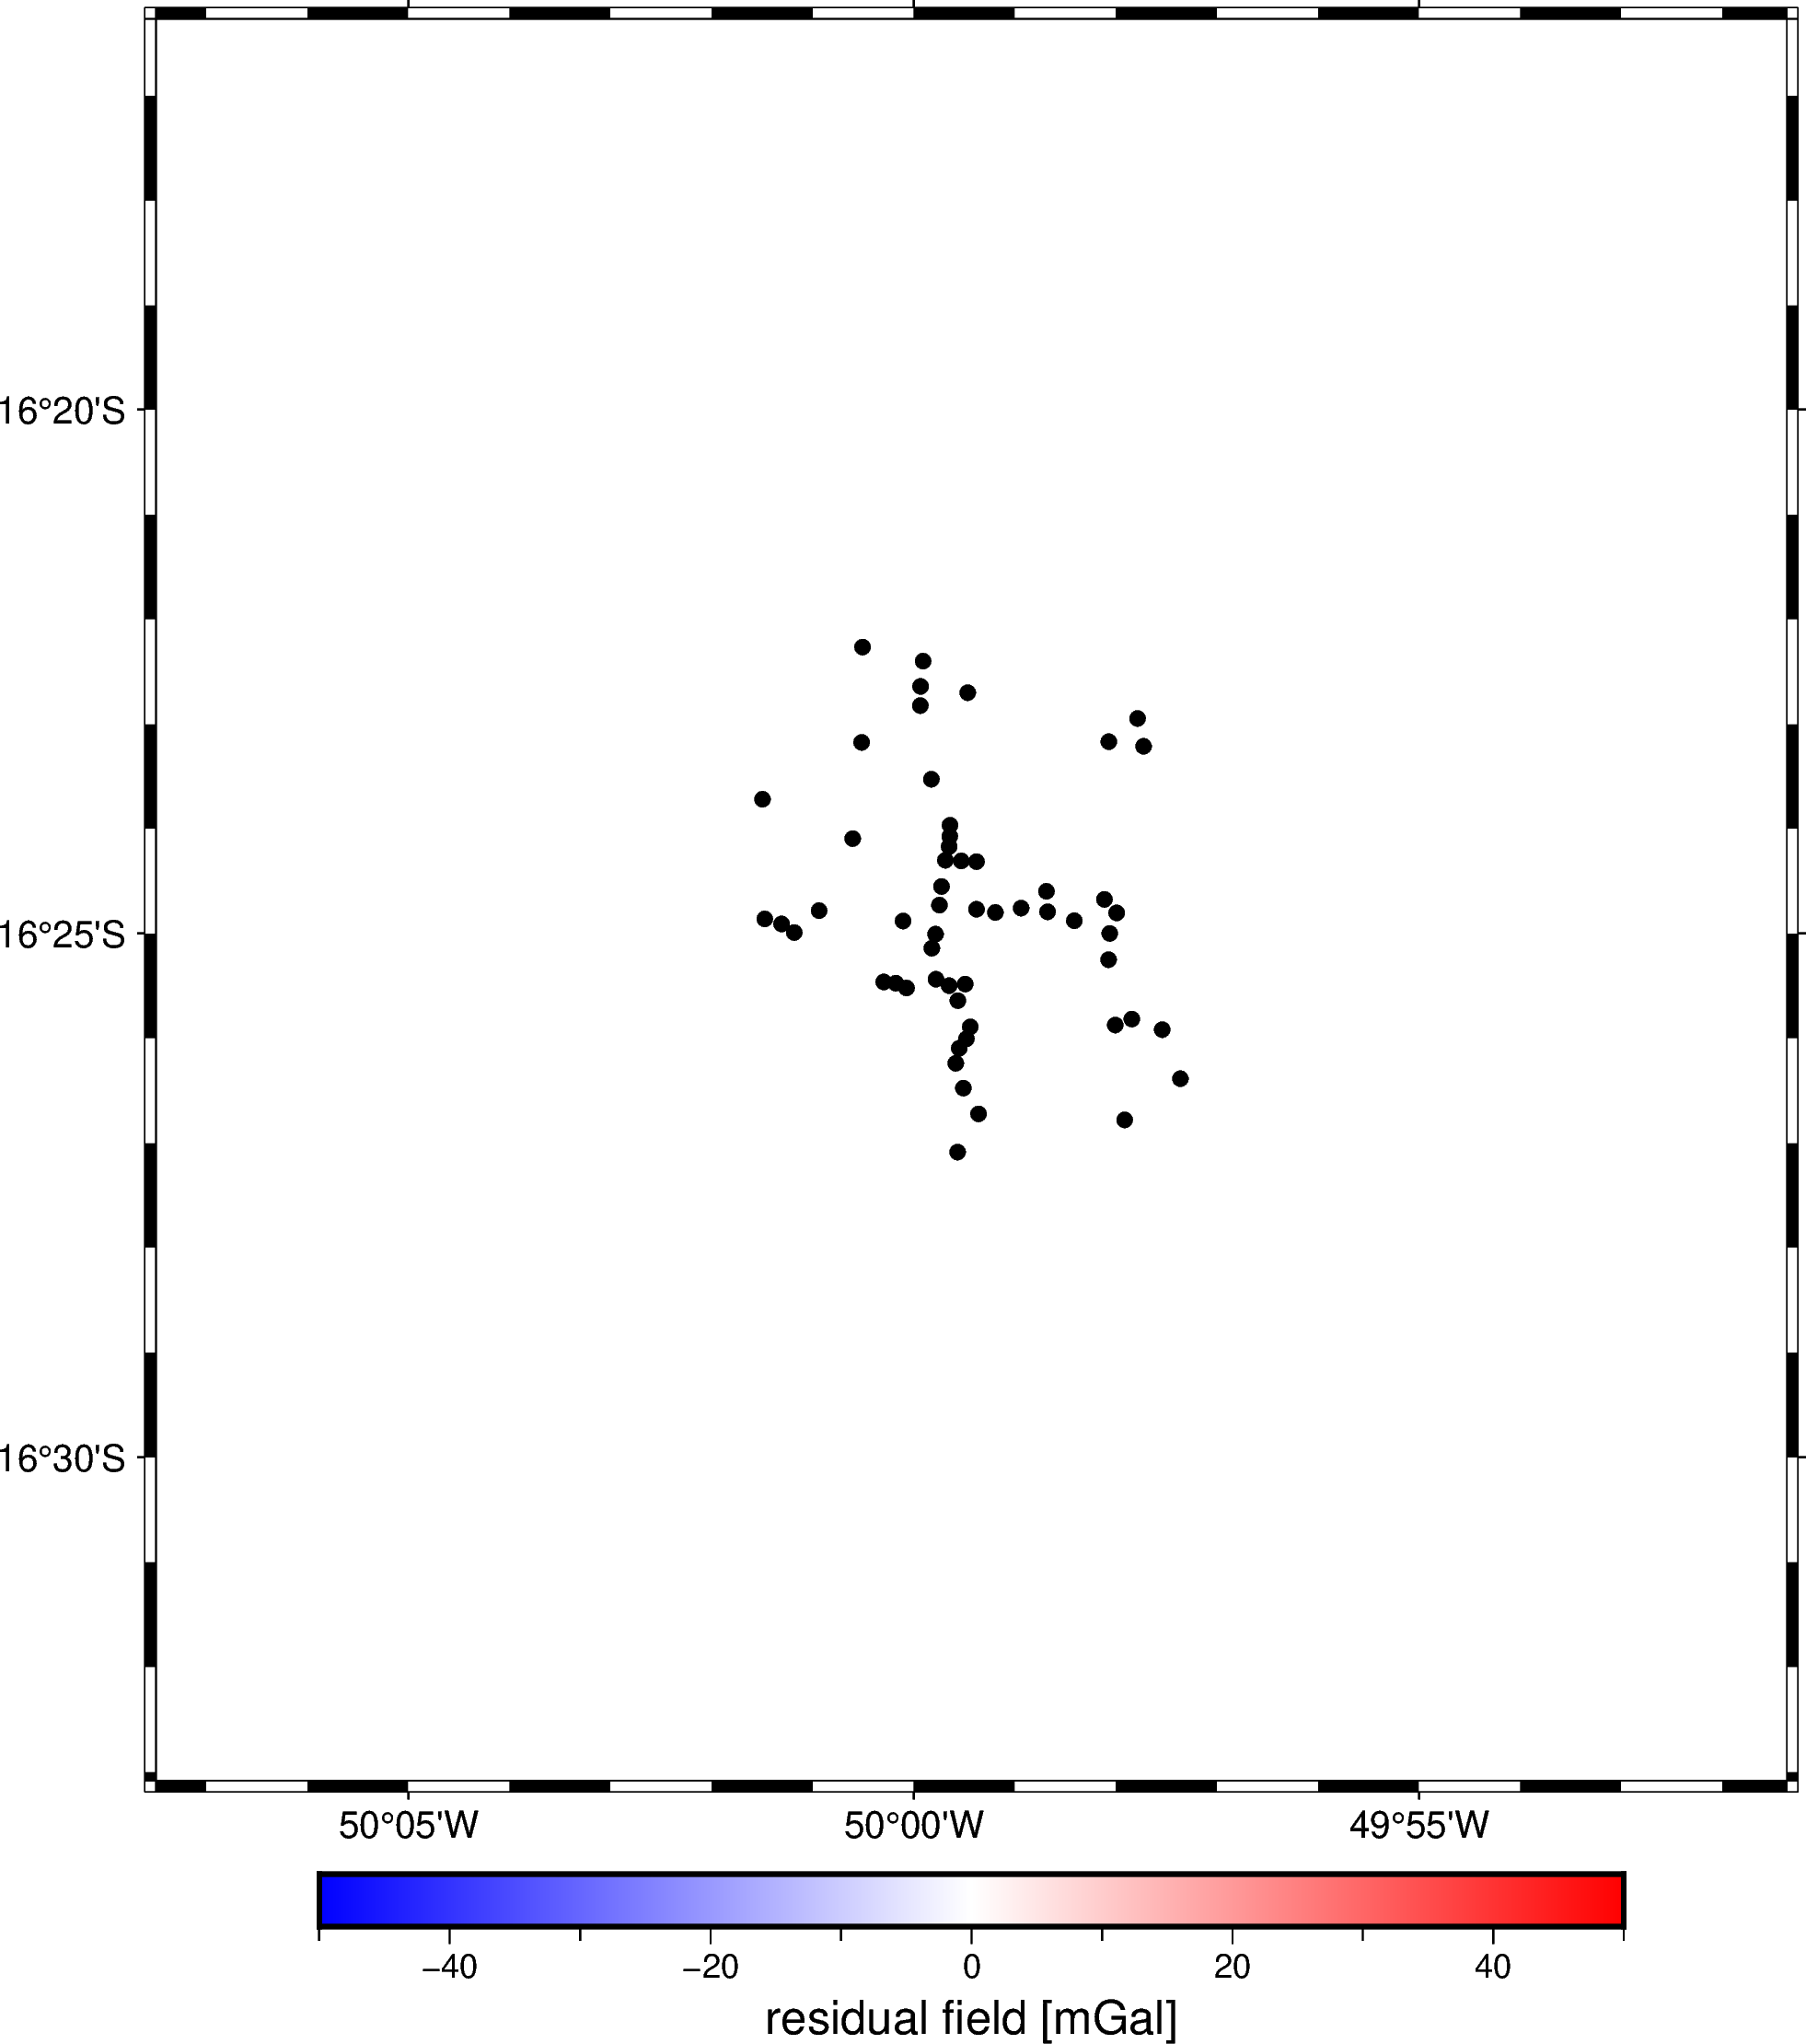

In [40]:
fig = pygmt.Figure()
# scale_max = data.gravity_bouguer_mgal.values.max()#vd.maxabs(residual_grid.gravity_residual)
# scale_min = data.gravity_bouguer_mgal.values.min()
# scale_max = data.residual_mgal.values.max()
# scale_min = data.residual_mgal.values.min()
# pygmt.makecpt(cmap="polar+h", series=[-12, 10], no_bg=True)
pygmt.makecpt(cmap="polar+h", series=[-50, 50], no_bg=True)
fig.grdimage(
    upward_cont,
    # shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
    region=vd.pad_region(region, pad=0.1)
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.Longitude,
    y=data.Latitude,
    style="c0.15c",
    color="black",
)
 
fig.show()

## image
<!-- ![](https://www.fatiando.org/tutorials/_images/bushveld_igneous_complex_geology.jpg) -->

# Calculate derivatives and gradients (new)

## Calculate derivatives

In [41]:
# grid_coords = vd.grid_coordinates(region, spacing=2 / 60, extra_coords=2.3e3)
g_east, g_north = projection(*coordinates_grid[:2])
g_up = coordinates_grid[2]

delta = 10
deast = (
      eqs.predict((g_east + delta, g_north, g_up))
    - eqs.predict((g_east - delta, g_north, g_up))
) / (2 * delta)

dnorth = (
      eqs.predict((g_east, g_north + delta, g_up))
    - eqs.predict((g_east, g_north - delta, g_up))
) / (2 * delta)



delta = 5
dup = (
      eqs.predict((g_east, g_north, g_up + delta))
    - eqs.predict((g_east, g_north, g_up - delta))
) / (2 * delta)


derivatives = vd.make_xarray_grid(coordinates_grid, (deast, dnorth, -dup), 
                                  data_names=["derivative_easting", "derivative_northing", "derivative_upward"],
                                  extra_coords_names="upward")

derivatives.derivative_easting.attrs = {"units": "mGal/m"}
derivatives.derivative_northing.attrs = {"units": "mGal/m"}
derivatives.derivative_upward.attrs = {"units": "mGal/m"}


## Calculate total and horizontal gradients

In [42]:
derivatives = derivatives.assign(TG=np.sqrt(derivatives.derivative_easting**2  +
                                            derivatives.derivative_northing**2 +
                                            derivatives.derivative_upward**2
                                               ))

derivatives = derivatives.assign(HG=np.sqrt(derivatives.derivative_easting**2  +
                                            derivatives.derivative_northing**2
                                               ))

derivatives.HG.attrs = {"units": "mGal/m"}
derivatives.TG.attrs = {"units": "mGal/m"}

In [43]:
derivatives

<xarray.Dataset> Size: 4MB
Dimensions:              (northing: 326, easting: 305)
Coordinates:
  * easting              (easting) float64 2kB -50.07 -50.07 ... -49.91 -49.91
  * northing             (northing) float64 3kB -16.5 -16.5 ... -16.32 -16.32
    upward               (northing, easting) float32 398kB 648.0 650.0 ... 797.0
Data variables:
    derivative_easting   (northing, easting) float64 795kB -0.0001602 ... 0.0...
    derivative_northing  (northing, easting) float64 795kB -0.000146 ... 3.66...
    derivative_upward    (northing, easting) float64 795kB -6.215e-05 ... -2....
    TG                   (northing, easting) float64 795kB 0.0002255 ... 0.00...
    HG                   (northing, easting) float64 795kB 0.0002168 ... 0.00...

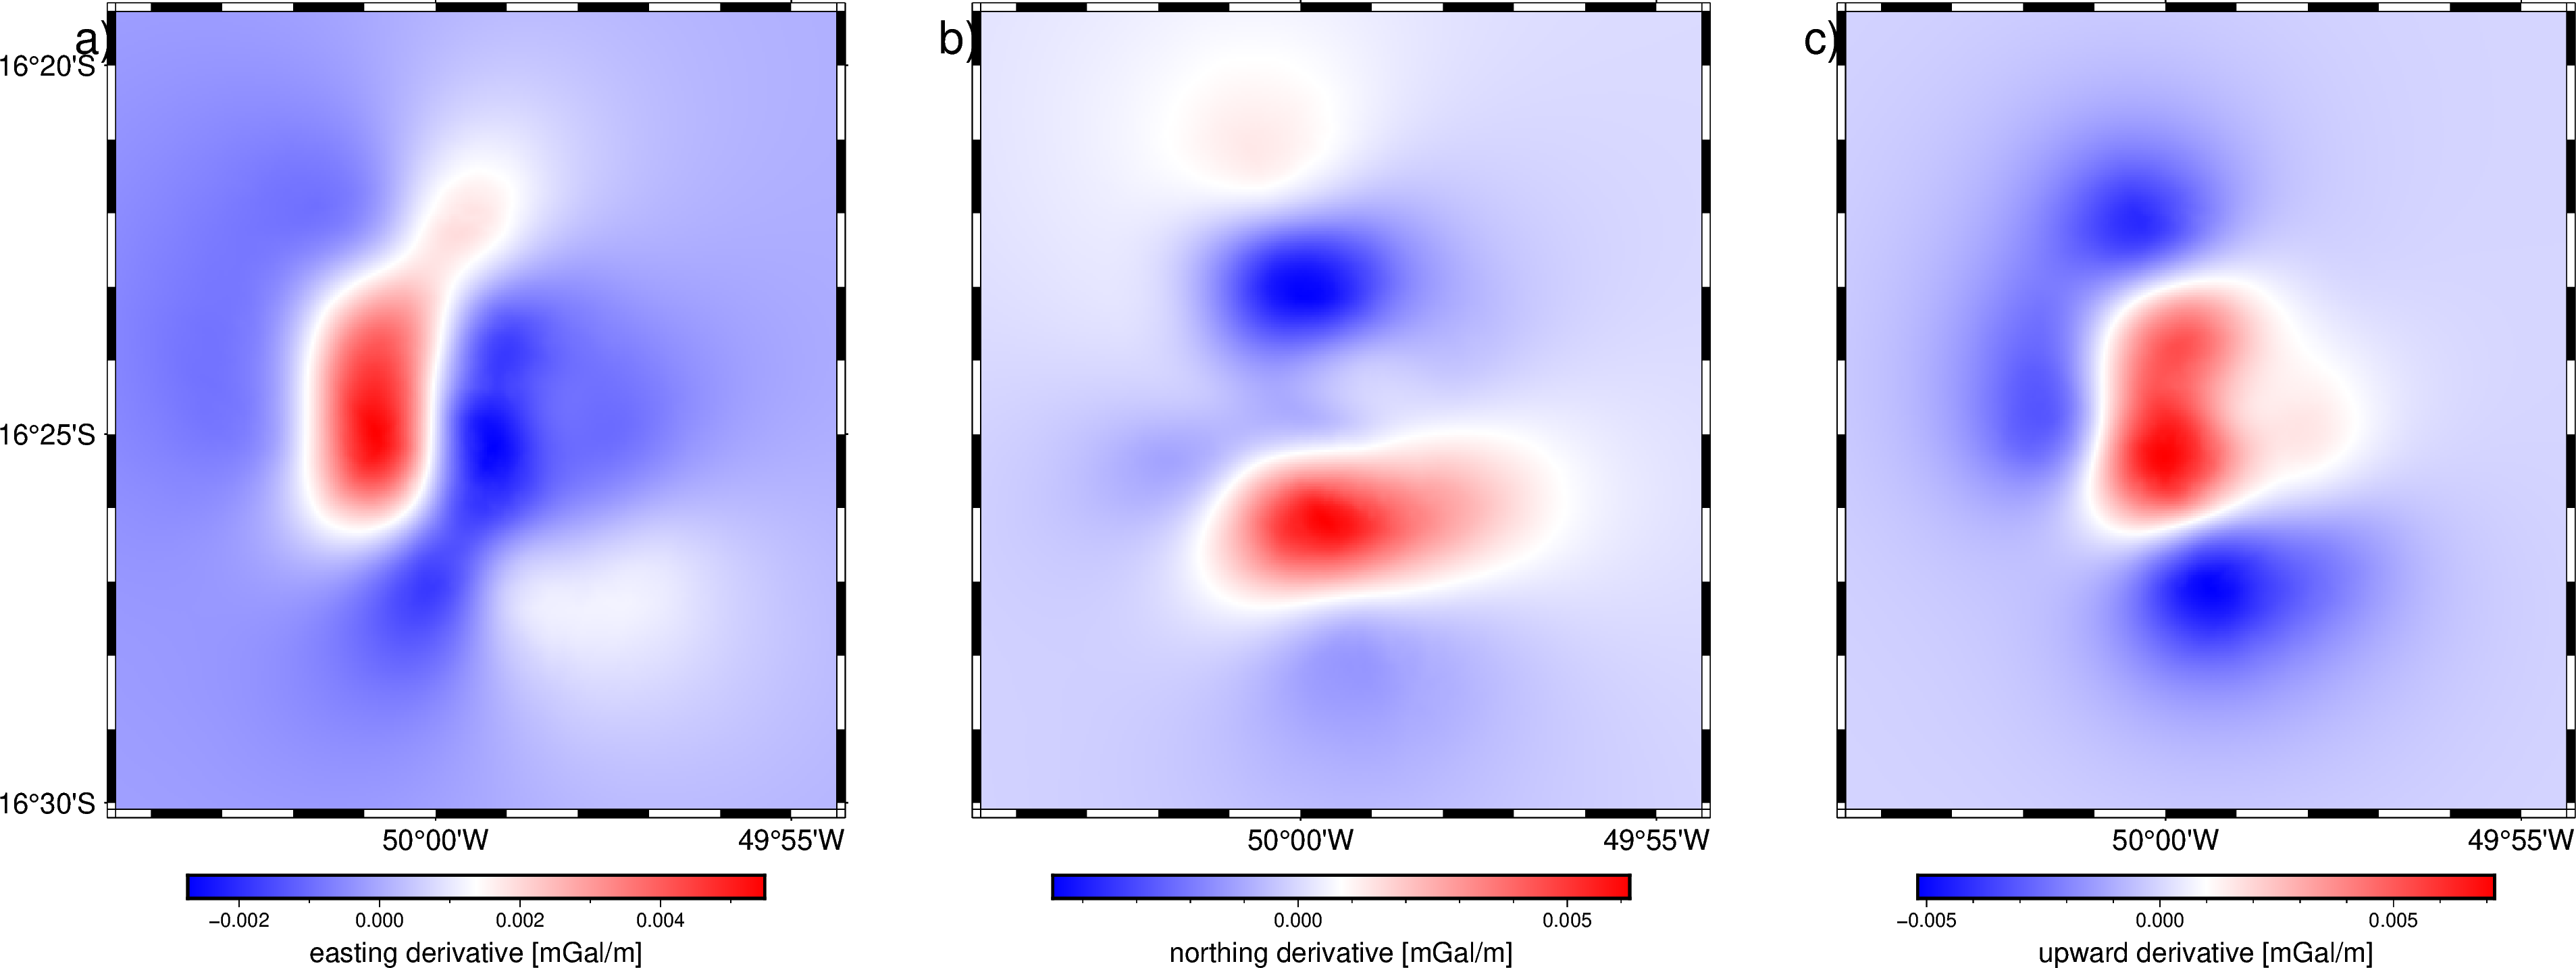

In [44]:
fig = pygmt.Figure()
# fig.subplot(nrows=1, ncols=3, figsize=("15c", "5c"), frame="a")
with fig.subplot(
    nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="0.01c"
):
    with fig.set_panel(panel=0):
        fig.grdimage(derivatives.derivative_easting, projection="M", cmap="polar", frame=["WSne", "xaf", "yaf"],
                    region= region_pad_2)# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
        fig.colorbar(frame='af+l"easting derivative [mGal/m]"')

    with fig.set_panel(panel=1):
        fig.grdimage(derivatives.derivative_northing, projection="M", cmap="polar", frame=["WSne", "xaf+lx-axis", "f+ly-axis"],
                    region= region_pad_2)
        fig.colorbar(frame='af+l"northing derivative [mGal/m]"')

    with fig.set_panel(panel=2):
        fig.grdimage(derivatives.derivative_upward, projection="M", cmap="polar", frame=["WSne", "xaf+lx-axis", "f+ly-axis"],
                    region= region_pad_2)
        fig.colorbar(frame='af+l"upward derivative [mGal/m]"')

# fig.savefig('teste.png', dpi=300)
fig.show()


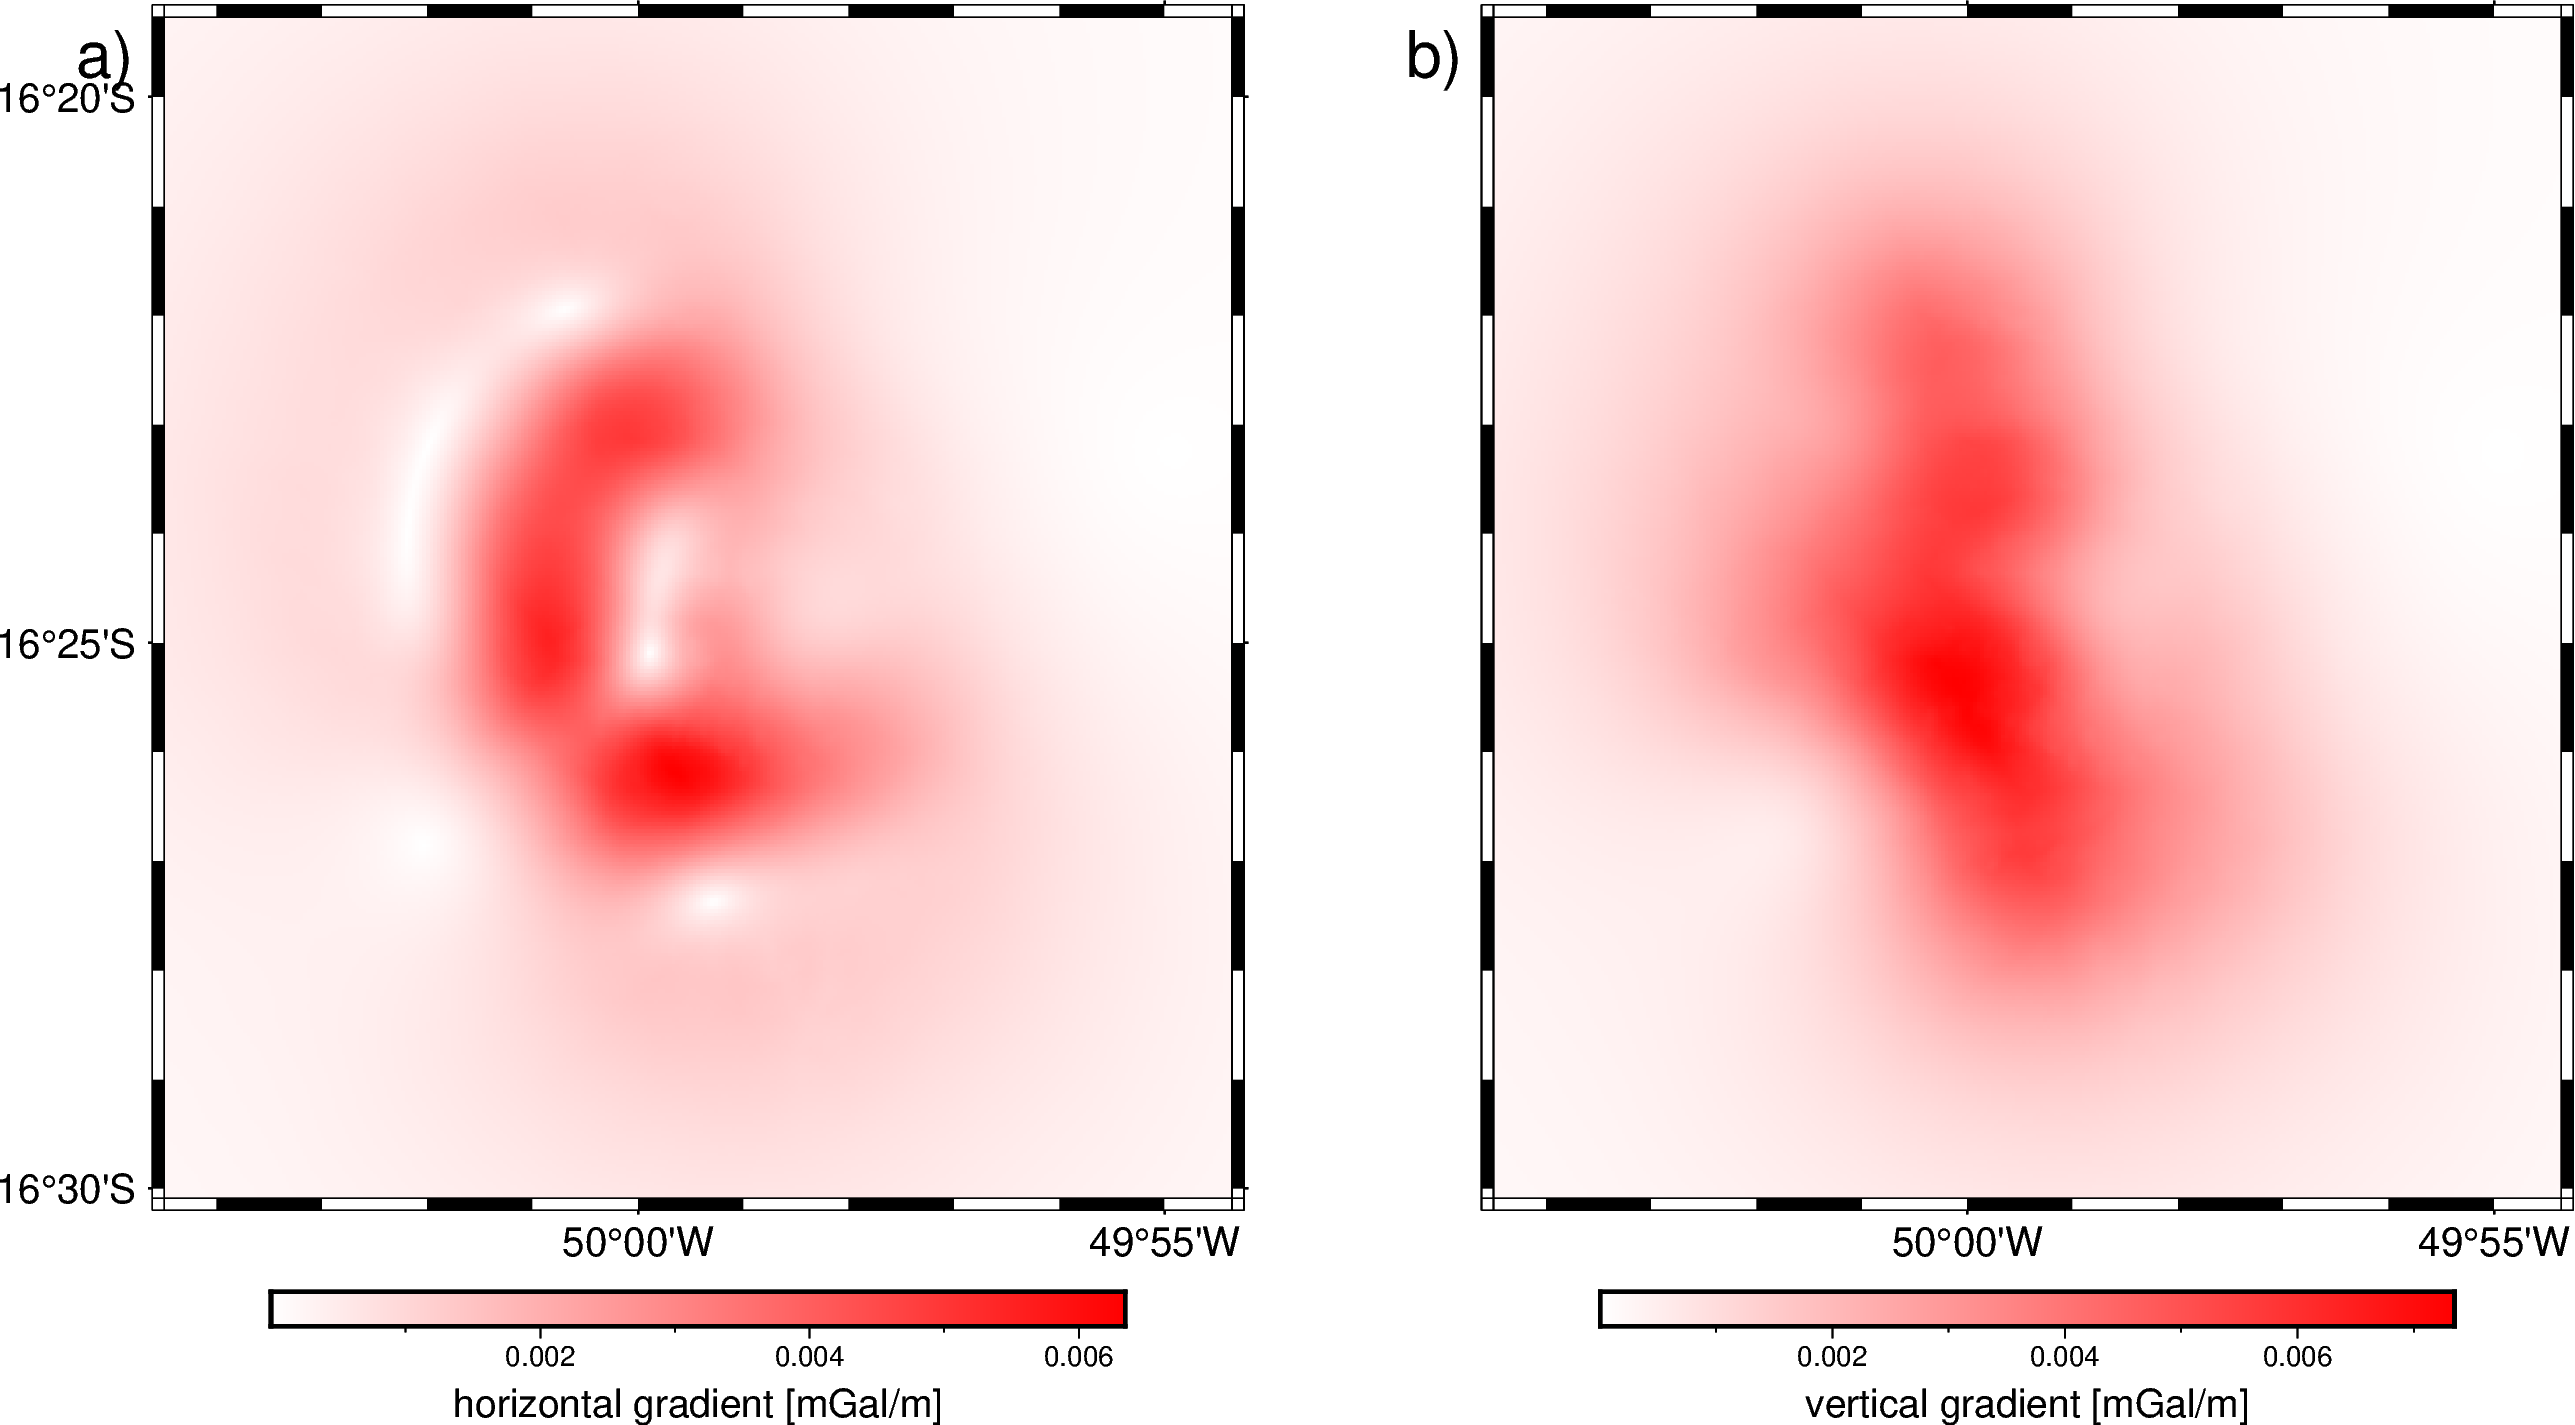

In [45]:
fig = pygmt.Figure()
# fig.subplot(nrows=1, ncols=3, figsize=("15c", "5c"), frame="a")
with fig.subplot(
    nrows=1, ncols=2, figsize=("22c", "10c"), autolabel=True, margins="0.01c"
):
    with fig.set_panel(panel=0):
        fig.grdimage(derivatives.HG, projection="M", cmap="polar+h", frame=["WSne", "xaf", "yaf"],
                    region= region_pad_2)# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
        fig.colorbar(frame='af+l"horizontal gradient [mGal/m]"')

    with fig.set_panel(panel=1):
        fig.grdimage(derivatives.TG, projection="M", cmap="polar+h", frame=["WSne", "xaf+lx-axis", "f+ly-axis"],
                    region= region_pad_2)
        fig.colorbar(frame='af+l"vertical gradient [mGal/m]"')

fig.show()

## Report's plot

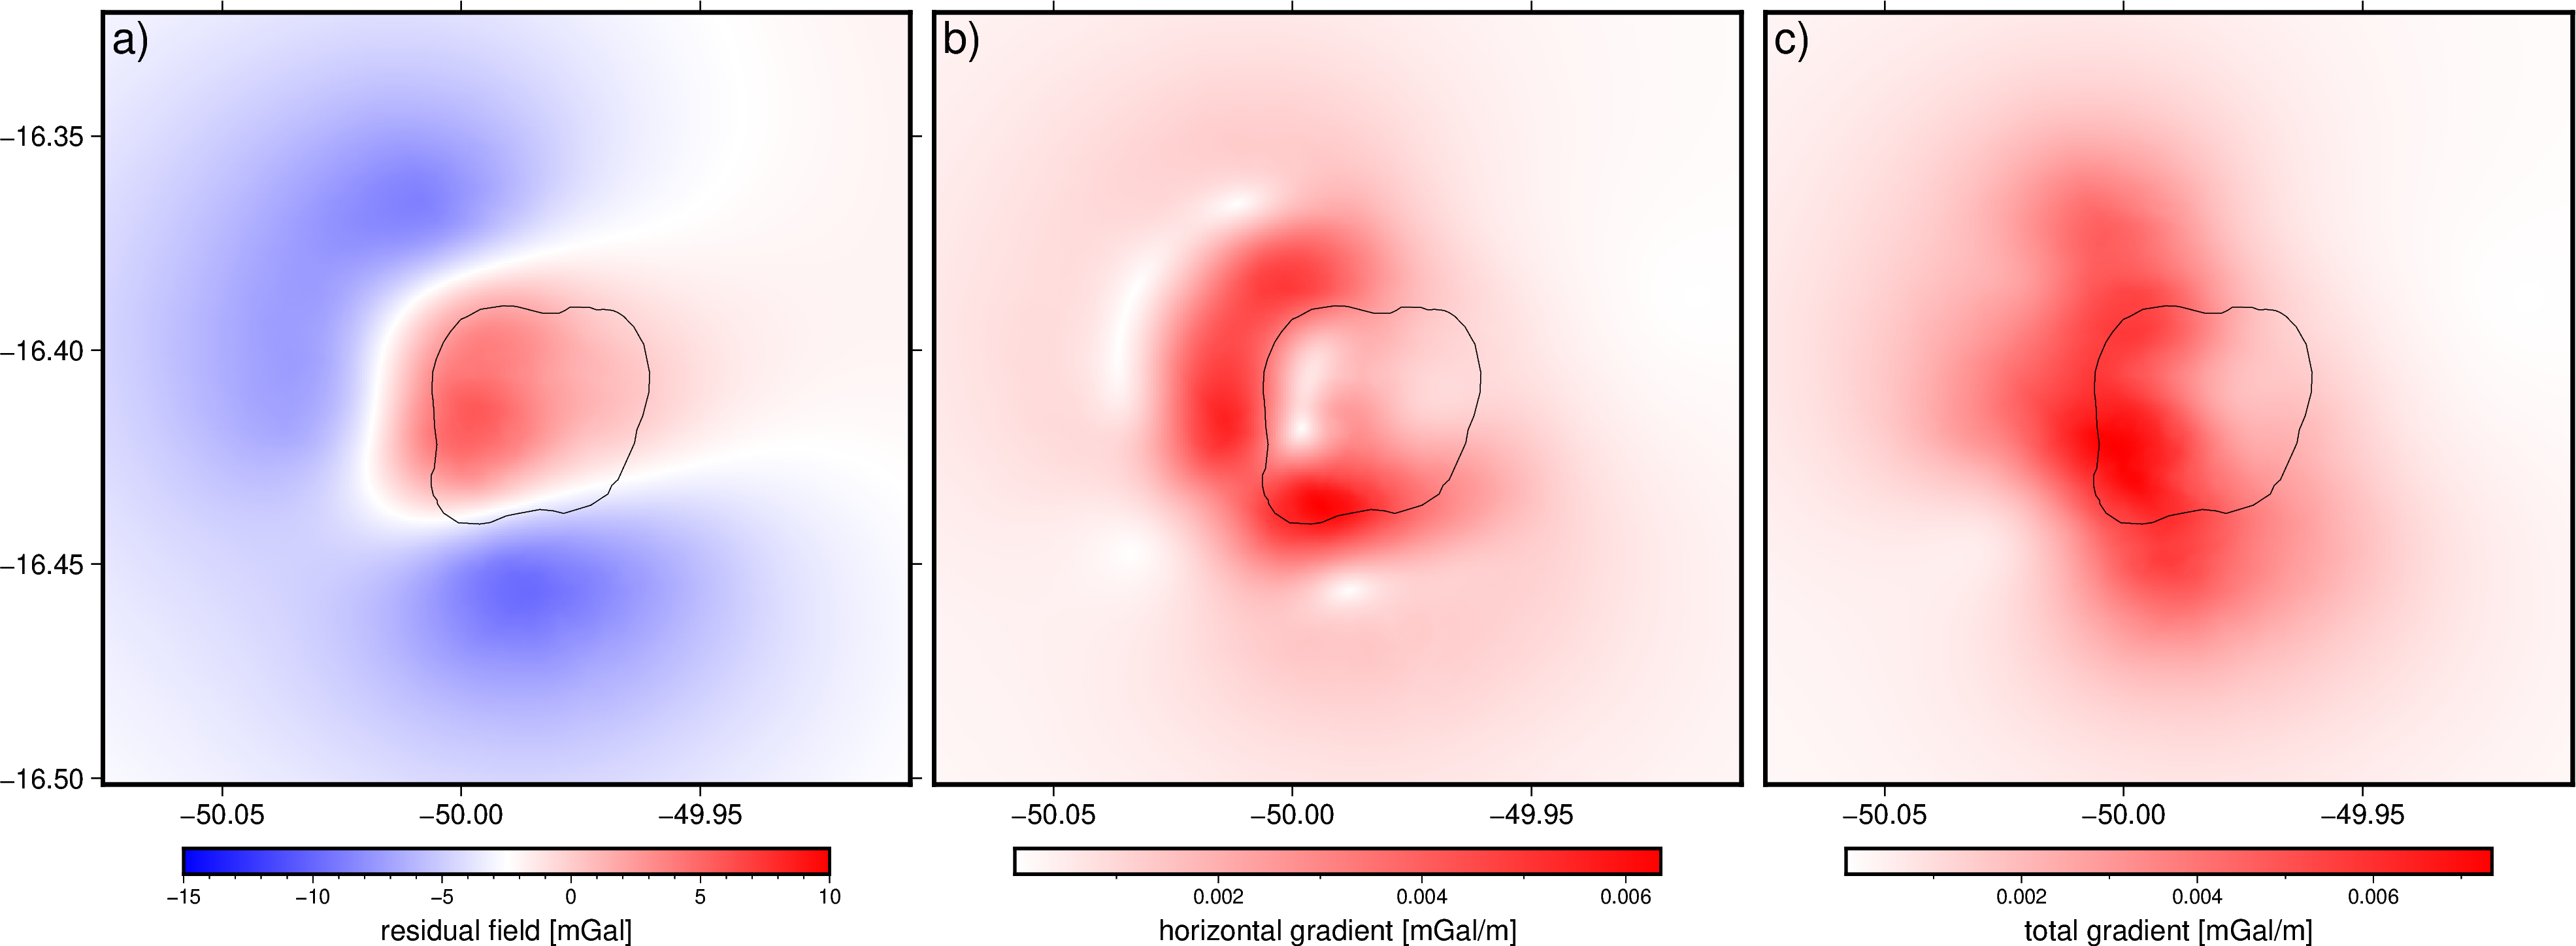

In [46]:
with plt.rc_context(mpl_rc):

    fig = pygmt.Figure()
    with fig.subplot(
        nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.1c/0.99c"
    ):
        
        with fig.set_panel(panel=0):
            scale = vd.maxabs(residual_grid.gravity_residual)
            pygmt.makecpt(cmap="polar", series=[-15, 10], no_bg=True)
            fig.grdimage(
                residual_grid.gravity_residual,
                # shading="+a45+nt0.15",
                projection="X",
                frame=["WSne", "xaf2.5", "yaf2.5"],
                region=region_pad_2
            )
            fig.colorbar(frame='af+l"residual field [mGal]"')
            fig.plot(data=pluton, projection='M')
        

        with fig.set_panel(panel=1):
            fig.grdimage(derivatives.HG, projection="X", cmap="polar+h", frame=["WSne", "xaf2.5", "yf2.5"],
                        region= region_pad_2)# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
            fig.colorbar(frame='af+l"horizontal gradient [mGal/m]"')
            fig.plot(data=pluton, projection='M')

        with fig.set_panel(panel=2):
            fig.grdimage(derivatives.TG, projection="X", cmap="polar+h", frame=["WSne", "xaf2.5", "f2.5"],
                        region= region_pad_2)
            fig.colorbar(frame='af+l"total gradient [mGal/m]"')
            fig.plot(data=pluton, projection='M')


fig.savefig(image_dir/'painel_final.png', dpi=300)
fig.show()

In [47]:
# with plt.rc_context(mpl_rc):

#     fig = pygmt.Figure()
#     with fig.subplot(
#         nrows=2, ncols=3, figsize=("32c", "20c"), autolabel=True, margins="-0.1c/0.99c"
#     ):
        
#         with fig.set_panel(panel=0):
#             scale = vd.maxabs(residual_grid.gravity_residual)
#             pygmt.makecpt(cmap="polar", series=[-10, 10], no_bg=True)
#             fig.grdimage(
#                 residual_grid.gravity_residual,
#                 # shading="+a45+nt0.15",
#                 projection="X",
#                 frame=["WSne", "xf2.5", "yaf2.5"],
#                 region=region_pad_2
#             )
#             fig.colorbar(frame='af+l"residual field [mGal]"')
#             fig.plot(data=GranitoFoliado, projection='M')
#             fig.plot(data=Mistura, projection='M')
#             fig.plot(data=Nucleo1, projection='M')
#             fig.plot(data=Nocleo2, projection='M')
#             fig.basemap(map_scale="n0.9/0.06+w5k+u")
        
#         with fig.set_panel(panel=1):
#             fig.grdimage(derivatives.derivative_easting, projection="X", cmap="polar", frame=["WSne", "xf2.5", "yf2.5"],
#                         region= region_pad_2)# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
#             fig.colorbar(frame='af+l"easting derivative [mGal/m]"')
#             # fig.text(text='b)', position='TL',  font=16)
#             fig.plot(data=GranitoFoliado, projection='M')
#             fig.plot(data=Mistura, projection='M')
#             fig.plot(data=Nucleo1, projection='M')
#             fig.plot(data=Nocleo2, projection='M')
#             fig.basemap(map_scale="n0.9/0.06+w5k+u")
        
    
#         with fig.set_panel(panel=2):
#             fig.grdimage(derivatives.derivative_northing, projection="X", cmap="polar", frame=["WSne", "xf2.5", "f2.5"],
#                         region= region_pad_2)
#             fig.colorbar(frame='af+l"northing derivative [mGal/m]"')
#             fig.plot(data=GranitoFoliado, projection='M')
#             fig.plot(data=Mistura, projection='M')
#             fig.plot(data=Nucleo1, projection='M')
#             fig.plot(data=Nocleo2, projection='M')
#             fig.basemap(map_scale="n0.9/0.06+w5k+u")

        
#         with fig.set_panel(panel=3):
#             fig.grdimage(derivatives.derivative_upward, projection="X", cmap="polar",  frame=["WSne", "xaf2.5", "yaf2.5"],
#                         region= region_pad_2)
#             fig.colorbar(frame='af+l"upward derivative [mGal/m]"')
#             fig.plot(data=GranitoFoliado, projection='M')
#             fig.plot(data=Mistura, projection='M')
#             fig.plot(data=Nucleo1, projection='M')
#             fig.plot(data=Nocleo2, projection='M')
#             fig.basemap(map_scale="n0.9/0.06+w5k+u")

#         with fig.set_panel(panel=4):
#             fig.grdimage(derivatives.HG, projection="X", cmap="polar+h", frame=["WSne", "xaf2.5", "yf2.5"],
#                         region= region_pad_2)# frame=["WSne", "xafg+lx-axis", "yafg+ly-axis"])
#             fig.colorbar(frame='af+l"horizontal gradient [mGal/m]"')
#             fig.plot(data=GranitoFoliado, projection='M')
#             fig.plot(data=Mistura, projection='M')
#             fig.plot(data=Nucleo1, projection='M')
#             fig.plot(data=Nocleo2, projection='M')
#             fig.basemap(map_scale="n0.9/0.06+w5k+u")
    
#         with fig.set_panel(panel=5):
#             fig.grdimage(derivatives.TG, projection="X", cmap="polar+h", frame=["WSne", "xaf2.5", "f2.5"],
#                         region= region_pad_2)
#             fig.colorbar(frame='af+l"vertical gradient [mGal/m]"')
#             fig.plot(data=GranitoFoliado, projection='M', label='geology boundaries')
#             fig.plot(data=Mistura, projection='M')
#             fig.plot(data=Nucleo1, projection='M')
#             fig.plot(data=Nocleo2, projection='M')
#             fig.legend(box=False, position="JTR+jTR+o0.2c")
#             fig.basemap(map_scale="n0.9/0.06+w5k+u")

# # fig.savefig(image_dir/'painel_final.png', dpi=300)
# fig.show()

In [48]:
print(np.max(data.residual_mgal))

9.456055875423928
